In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from sympy import *
from sympy.physics.mechanics import dynamicsymbols, init_vprinting, msubs
from IPython.display import Image
from IPython.core.display import HTML
import scipy.integrate
import math
from numpy.linalg import matrix_power
from scipy.linalg import expm
import os
import time
from itertools import count, takewhile
from more_itertools import numeric_range
from playsound import playsound
from tqdm import tqdm

%matplotlib notebook

In [3]:
def discretize_ss(A, B, dt):
    A_B = np.block([[A, B],
                [np.zeros((B.shape[1], A.shape[0])), np.zeros((B.shape[1], B.shape[1]))]])

    eAt_d = scipy.linalg.expm(A_B * dt)

    A_d_temp = eAt_d[:A.shape[0], :A.shape[0]]

    B_d_temp = eAt_d[:B.shape[0], A.shape[0]:]

    return (A_d_temp, B_d_temp)

In [4]:
def get_integrated_position_trajectory(initial_pos, vel_desired):
    x_ref_temp = np.zeros((n, N))

    pos_desired = initial_pos
    for i in range(0, N):
        pos_desired += vel_desired * dt
        x_ref_temp[:, i] = np.array([0, 0, 0, 0, pos_desired, 1, 0, 0, 0, 0, vel_desired, 0, -9.81])
        
    return x_ref_temp

In [5]:
def get_joint_torques(f_x, f_y, f_z, theta1, theta2, theta3, theta4, theta5, phi, theta, psi):
    return np.array([[f_x*(0.41*sin(theta2)*sin(psi + theta1)*cos(theta3) + 0.4*sin(theta2)*sin(psi + theta1)*cos(theta3 + theta4) + 0.04*sin(theta2)*sin(psi + theta1)*cos(theta3 + theta4 + theta5) - 0.41*sin(theta3)*cos(psi + theta1) - 0.4*sin(theta3 + theta4)*cos(psi + theta1) - 0.04*sin(theta3 + theta4 + theta5)*cos(psi + theta1))*cos(theta) + f_y*((sin(phi)*sin(psi)*sin(theta) - cos(phi)*cos(psi))*(0.41*sin(theta1)*sin(theta3) + 0.4*sin(theta1)*sin(theta3 + theta4) + 0.04*sin(theta1)*sin(theta3 + theta4 + theta5) + 0.41*sin(theta2)*cos(theta1)*cos(theta3) + 0.4*sin(theta2)*cos(theta1)*cos(theta3 + theta4) + 0.04*sin(theta2)*cos(theta1)*cos(theta3 + theta4 + theta5)) + (sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi))*(0.41*sin(theta1)*sin(theta2)*cos(theta3) + 0.4*sin(theta1)*sin(theta2)*cos(theta3 + theta4) + 0.04*sin(theta1)*sin(theta2)*cos(theta3 + theta4 + theta5) - 0.41*sin(theta3)*cos(theta1) - 0.4*sin(theta3 + theta4)*cos(theta1) - 0.04*sin(theta3 + theta4 + theta5)*cos(theta1))) + f_z*((sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi))*(0.41*sin(theta1)*sin(theta2)*cos(theta3) + 0.4*sin(theta1)*sin(theta2)*cos(theta3 + theta4) + 0.04*sin(theta1)*sin(theta2)*cos(theta3 + theta4 + theta5) - 0.41*sin(theta3)*cos(theta1) - 0.4*sin(theta3 + theta4)*cos(theta1) - 0.04*sin(theta3 + theta4 + theta5)*cos(theta1)) - (sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))*(0.41*sin(theta1)*sin(theta3) + 0.4*sin(theta1)*sin(theta3 + theta4) + 0.04*sin(theta1)*sin(theta3 + theta4 + theta5) + 0.41*sin(theta2)*cos(theta1)*cos(theta3) + 0.4*sin(theta2)*cos(theta1)*cos(theta3 + theta4) + 0.04*sin(theta2)*cos(theta1)*cos(theta3 + theta4 + theta5)))], [f_x*((0.41*sin(theta2)*cos(theta3) + 0.4*sin(theta2)*cos(theta3 + theta4) + 0.04*sin(theta2)*cos(theta3 + theta4 + theta5))*sin(theta) + (0.41*cos(theta2)*cos(theta3) + 0.4*cos(theta2)*cos(theta3 + theta4) + 0.04*cos(theta2)*cos(theta3 + theta4 + theta5))*sin(psi)*sin(theta1)*cos(theta) - (0.41*cos(theta2)*cos(theta3) + 0.4*cos(theta2)*cos(theta3 + theta4) + 0.04*cos(theta2)*cos(theta3 + theta4 + theta5))*cos(psi)*cos(theta)*cos(theta1)) - f_y*(-(sin(phi)*sin(psi)*sin(theta) - cos(phi)*cos(psi))*(0.41*cos(theta2)*cos(theta3) + 0.4*cos(theta2)*cos(theta3 + theta4) + 0.04*cos(theta2)*cos(theta3 + theta4 + theta5))*sin(theta1) + (sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi))*(0.41*cos(theta2)*cos(theta3) + 0.4*cos(theta2)*cos(theta3 + theta4) + 0.04*cos(theta2)*cos(theta3 + theta4 + theta5))*cos(theta1) + (0.41*sin(theta2)*cos(theta3) + 0.4*sin(theta2)*cos(theta3 + theta4) + 0.04*sin(theta2)*cos(theta3 + theta4 + theta5))*sin(phi)*cos(theta)) - f_z*((sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi))*(0.41*cos(theta2)*cos(theta3) + 0.4*cos(theta2)*cos(theta3 + theta4) + 0.04*cos(theta2)*cos(theta3 + theta4 + theta5))*cos(theta1) + (sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))*(0.41*cos(theta2)*cos(theta3) + 0.4*cos(theta2)*cos(theta3 + theta4) + 0.04*cos(theta2)*cos(theta3 + theta4 + theta5))*sin(theta1) - (0.41*sin(theta2)*cos(theta3) + 0.4*sin(theta2)*cos(theta3 + theta4) + 0.04*sin(theta2)*cos(theta3 + theta4 + theta5))*cos(phi)*cos(theta))], [-f_x*(-0.41*sin(theta)*sin(theta3)*cos(theta2) - 0.4*sin(theta)*sin(theta3 + theta4)*cos(theta2) - 0.04*sin(theta)*sin(theta3 + theta4 + theta5)*cos(theta2) - 0.41*sin(theta2)*sin(theta3)*cos(theta)*cos(psi + theta1) - 0.4*sin(theta2)*sin(theta3 + theta4)*cos(theta)*cos(psi + theta1) - 0.04*sin(theta2)*sin(theta3 + theta4 + theta5)*cos(theta)*cos(psi + theta1) + 0.41*sin(psi + theta1)*cos(theta)*cos(theta3) + 0.4*sin(psi + theta1)*cos(theta)*cos(theta3 + theta4) + 0.04*sin(psi + theta1)*cos(theta)*cos(theta3 + theta4 + theta5)) - f_y*((sin(phi)*sin(psi)*sin(theta) - cos(phi)*cos(psi))*(0.41*sin(theta1)*sin(theta2)*sin(theta3) + 0.4*sin(theta1)*sin(theta2)*sin(theta3 + theta4) + 0.04*sin(theta1)*sin(theta2)*sin(theta3 + theta4 + theta5) + 0.41*cos(theta1)*cos(theta3) + 0.4*cos(theta1)*cos(theta3 + theta4) + 0.04*cos(theta1)*cos(theta3 + theta4 + theta5)) + (sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi))*(0.41*sin(theta1)*cos(theta3) + 0.4*sin(theta1)*cos(theta3 + theta4) + 0.04*sin(theta1)*cos(theta3 + theta4 + theta5) - 0.41*sin(theta2)*sin(theta3)*cos(theta1) - 0.4*sin(theta2)*sin(theta3 + theta4)*cos(theta1) - 0.04*sin(theta2)*sin(theta3 + theta4 + theta5)*cos(theta1)) - (-0.41*sin(theta3) - 0.4*sin(theta3 + theta4) - 0.04*sin(theta3 + theta4 + theta5))*sin(phi)*cos(theta)*cos(theta2)) - f_z*((sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi))*(0.41*sin(theta1)*cos(theta3) + 0.4*sin(theta1)*cos(theta3 + theta4) + 0.04*sin(theta1)*cos(theta3 + theta4 + theta5) - 0.41*sin(theta2)*sin(theta3)*cos(theta1) - 0.4*sin(theta2)*sin(theta3 + theta4)*cos(theta1) - 0.04*sin(theta2)*sin(theta3 + theta4 + theta5)*cos(theta1)) - (sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))*(0.41*sin(theta1)*sin(theta2)*sin(theta3) + 0.4*sin(theta1)*sin(theta2)*sin(theta3 + theta4) + 0.04*sin(theta1)*sin(theta2)*sin(theta3 + theta4 + theta5) + 0.41*cos(theta1)*cos(theta3) + 0.4*cos(theta1)*cos(theta3 + theta4) + 0.04*cos(theta1)*cos(theta3 + theta4 + theta5)) + (-0.41*sin(theta3) - 0.4*sin(theta3 + theta4) - 0.04*sin(theta3 + theta4 + theta5))*cos(phi)*cos(theta)*cos(theta2))], [-f_x*(-0.4*sin(theta)*sin(theta3 + theta4)*cos(theta2) - 0.04*sin(theta)*sin(theta3 + theta4 + theta5)*cos(theta2) - 0.4*sin(theta2)*sin(theta3 + theta4)*cos(theta)*cos(psi + theta1) - 0.04*sin(theta2)*sin(theta3 + theta4 + theta5)*cos(theta)*cos(psi + theta1) + 0.4*sin(psi + theta1)*cos(theta)*cos(theta3 + theta4) + 0.04*sin(psi + theta1)*cos(theta)*cos(theta3 + theta4 + theta5)) - f_y*((sin(phi)*sin(psi)*sin(theta) - cos(phi)*cos(psi))*(0.4*sin(theta1)*sin(theta2)*sin(theta3 + theta4) + 0.04*sin(theta1)*sin(theta2)*sin(theta3 + theta4 + theta5) + 0.4*cos(theta1)*cos(theta3 + theta4) + 0.04*cos(theta1)*cos(theta3 + theta4 + theta5)) + (sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi))*(0.4*sin(theta1)*cos(theta3 + theta4) + 0.04*sin(theta1)*cos(theta3 + theta4 + theta5) - 0.4*sin(theta2)*sin(theta3 + theta4)*cos(theta1) - 0.04*sin(theta2)*sin(theta3 + theta4 + theta5)*cos(theta1)) - (-0.4*sin(theta3 + theta4) - 0.04*sin(theta3 + theta4 + theta5))*sin(phi)*cos(theta)*cos(theta2)) - f_z*((sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi))*(0.4*sin(theta1)*cos(theta3 + theta4) + 0.04*sin(theta1)*cos(theta3 + theta4 + theta5) - 0.4*sin(theta2)*sin(theta3 + theta4)*cos(theta1) - 0.04*sin(theta2)*sin(theta3 + theta4 + theta5)*cos(theta1)) - (sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))*(0.4*sin(theta1)*sin(theta2)*sin(theta3 + theta4) + 0.04*sin(theta1)*sin(theta2)*sin(theta3 + theta4 + theta5) + 0.4*cos(theta1)*cos(theta3 + theta4) + 0.04*cos(theta1)*cos(theta3 + theta4 + theta5)) + (-0.4*sin(theta3 + theta4) - 0.04*sin(theta3 + theta4 + theta5))*cos(phi)*cos(theta)*cos(theta2))], [-f_x*(-0.04*sin(theta)*sin(theta3 + theta4 + theta5)*cos(theta2) - 0.04*sin(theta2)*sin(theta3 + theta4 + theta5)*cos(theta)*cos(psi + theta1) + 0.04*sin(psi + theta1)*cos(theta)*cos(theta3 + theta4 + theta5)) - f_y*(-0.04*(-sin(theta1)*cos(theta3 + theta4 + theta5) + sin(theta2)*sin(theta3 + theta4 + theta5)*cos(theta1))*(sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi)) + 0.04*(sin(phi)*sin(psi)*sin(theta) - cos(phi)*cos(psi))*(sin(theta1)*sin(theta2)*sin(theta3 + theta4 + theta5) + cos(theta1)*cos(theta3 + theta4 + theta5)) + 0.04*sin(phi)*sin(theta3 + theta4 + theta5)*cos(theta)*cos(theta2)) - f_z*(-0.04*(sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi))*(-sin(theta1)*cos(theta3 + theta4 + theta5) + sin(theta2)*sin(theta3 + theta4 + theta5)*cos(theta1)) - 0.04*(sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))*(sin(theta1)*sin(theta2)*sin(theta3 + theta4 + theta5) + cos(theta1)*cos(theta3 + theta4 + theta5)) - 0.04*sin(theta3 + theta4 + theta5)*cos(phi)*cos(theta)*cos(theta2))]])

P_cols: 141
Minimum possible Force in X and Y direction: -800.0
Maximum possible Force in X and Y direction: 800.0
Compiling C Code for solver...


  1%|          | 4/401 [00:00<00:10, 36.79it/s]

Finished compiling.
Entering main MPC loop...


100%|██████████| 401/401 [00:08<00:00, 46.70it/s]

Final MPC iterations: 401
-------------------
Steady state error:
 [[ 1.06460423e-16]
 [-2.29228695e-02]
 [-1.19683554e-16]
 [ 1.72026423e-02]
 [ 1.15927192e-15]
 [-1.08390549e-03]
 [ 3.90352537e-15]
 [-7.54849456e-01]
 [ 6.50865439e-16]
 [-1.43045844e-01]
 [-3.28738661e-17]
 [ 4.00342560e-03]
 [ 0.00000000e+00]]
---------------------------
RMS Error:
 [[4.02172789e-16]
 [6.07300010e-02]
 [3.57211777e-16]
 [2.55044895e-02]
 [7.32027346e-16]
 [1.74096443e-02]
 [9.61006482e-15]
 [6.69599459e-01]
 [1.47402050e-15]
 [1.65864329e-01]
 [4.46571396e-16]
 [4.66529787e-02]
 [0.00000000e+00]]
Average solver time: 19.092903470160657
Max solver time: 43.264150619506836
Min solver time: 15.195846557617188


<IPython.core.display.Javascript object>


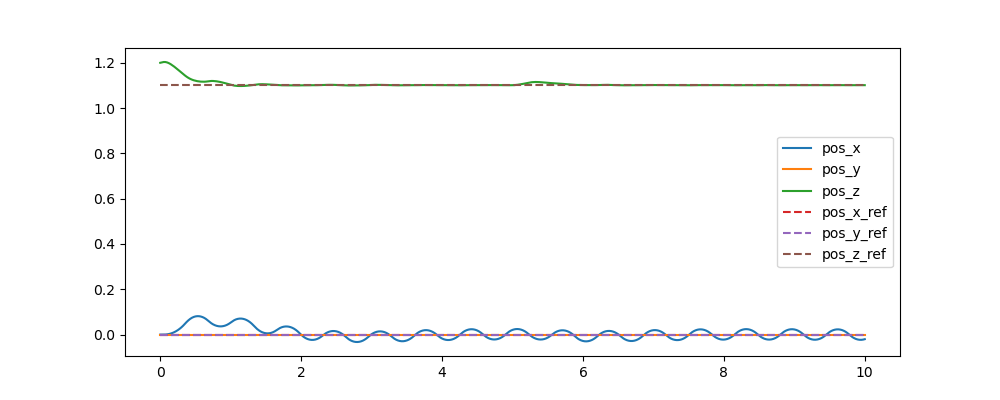

<IPython.core.display.Javascript object>


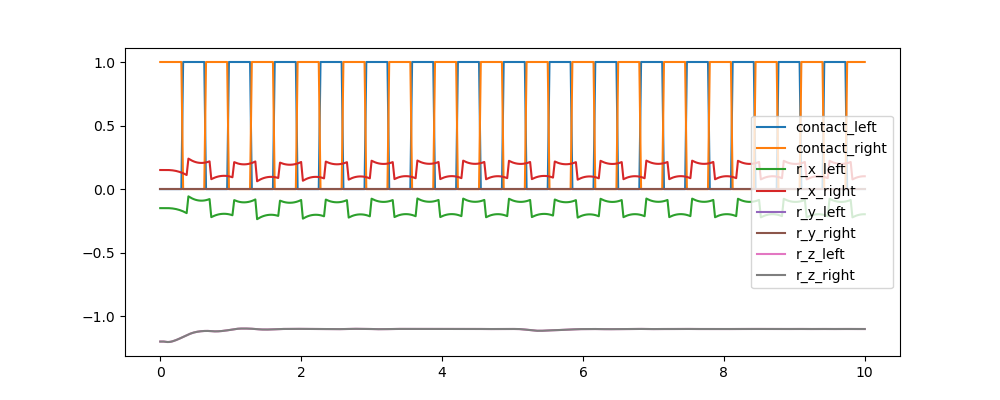

/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>


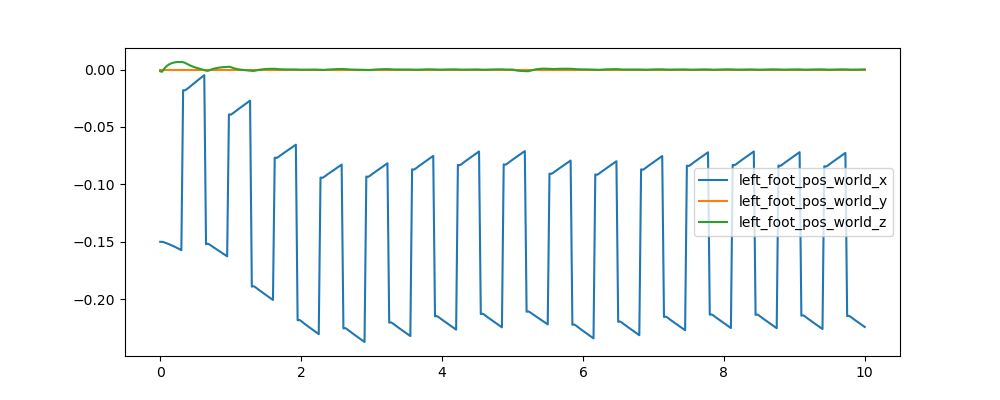

<IPython.core.display.Javascript object>


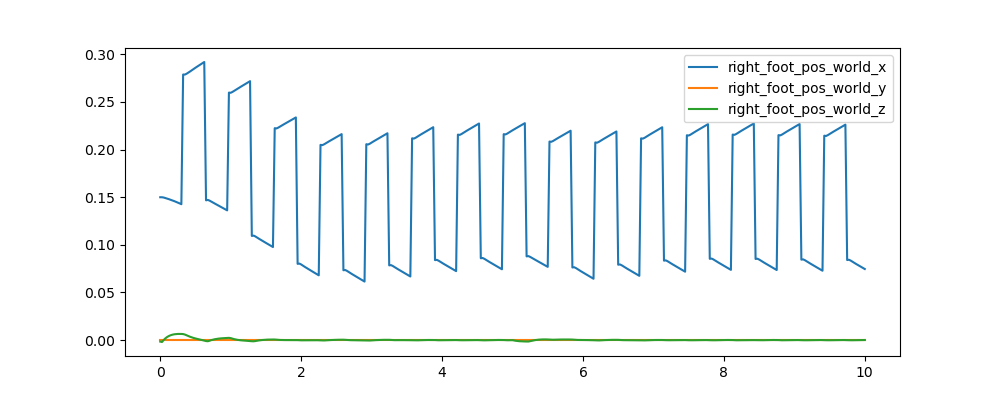

<IPython.core.display.Javascript object>


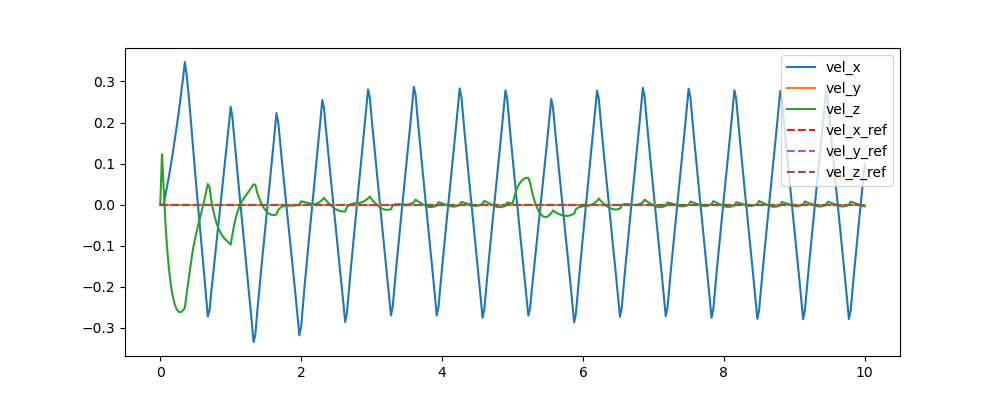

<IPython.core.display.Javascript object>


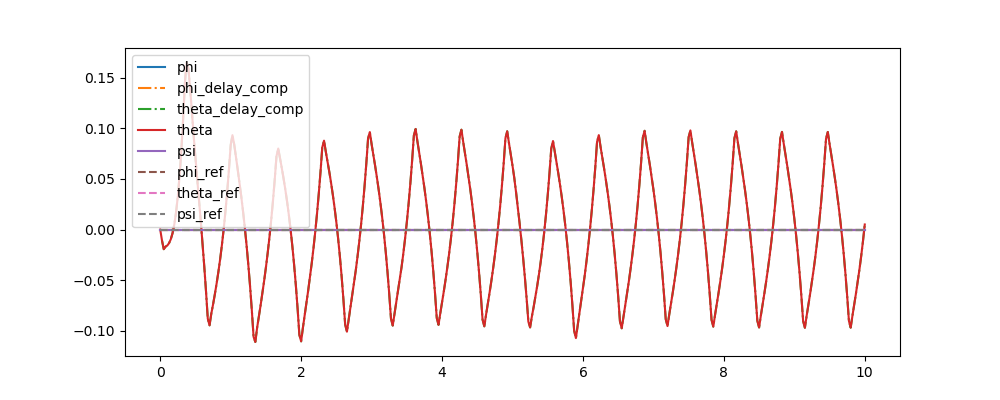

<IPython.core.display.Javascript object>


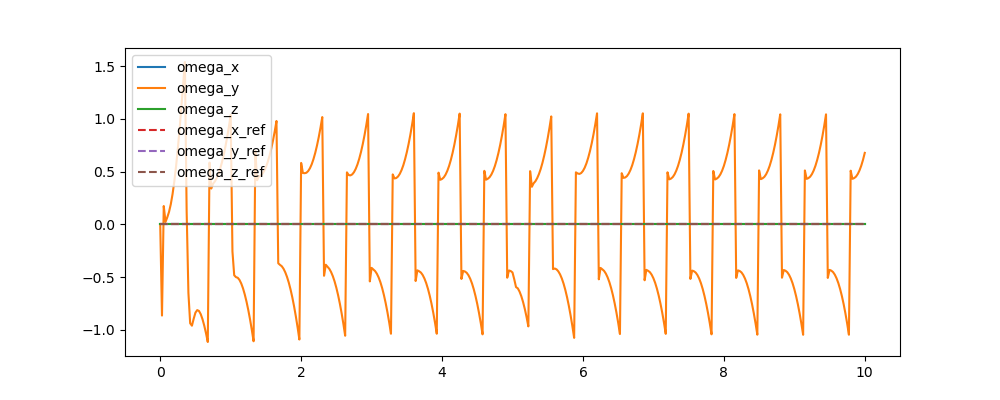

<IPython.core.display.Javascript object>


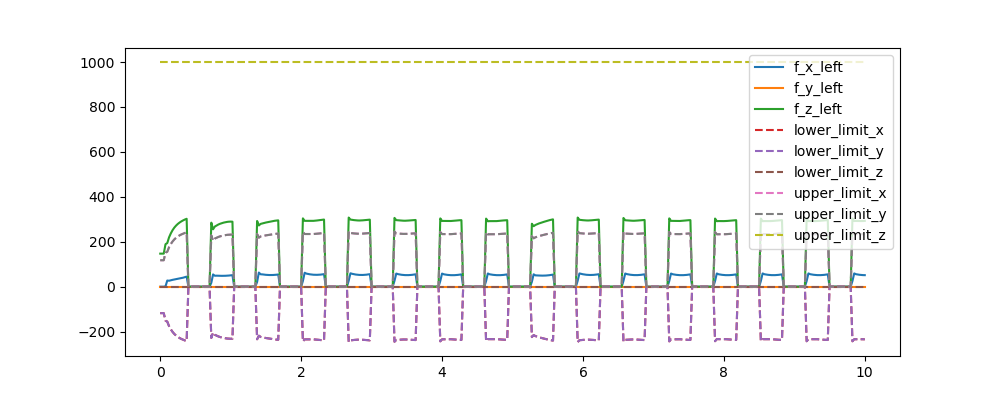

<IPython.core.display.Javascript object>


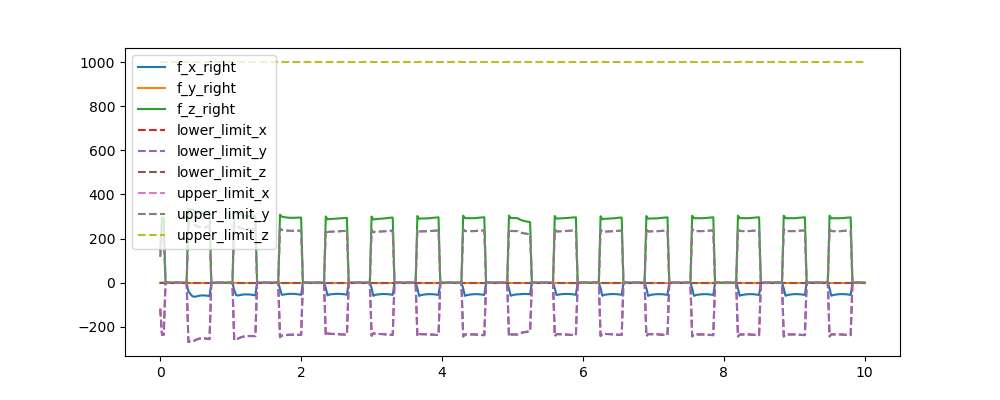

<IPython.core.display.Javascript object>


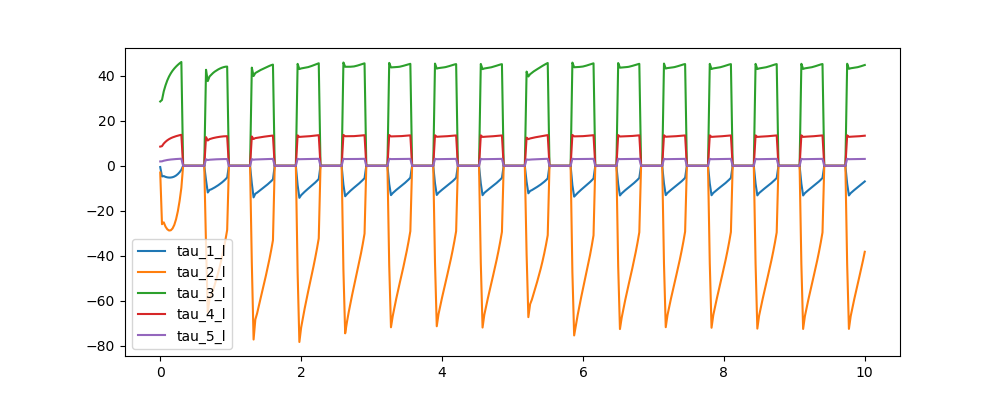

<IPython.core.display.Javascript object>


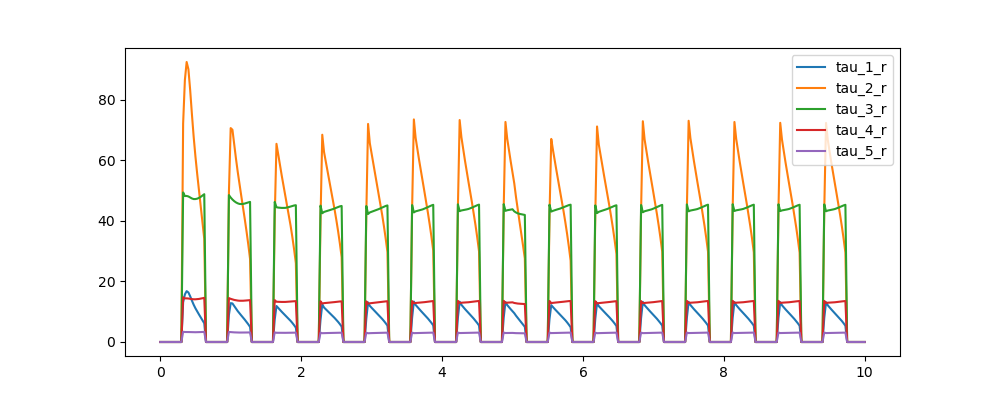

<IPython.core.display.Javascript object>


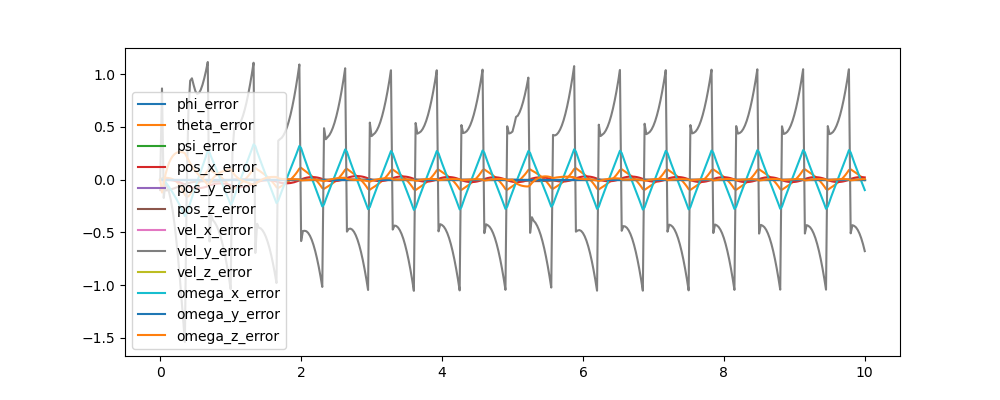

<IPython.core.display.Javascript object>


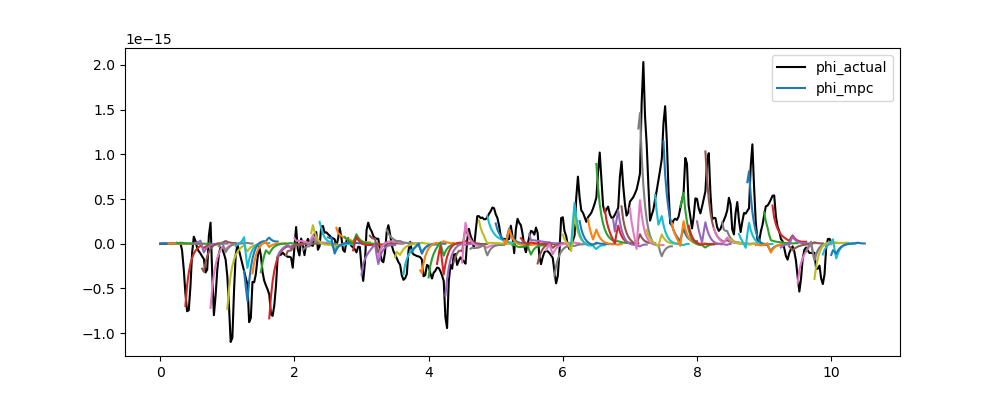

<IPython.core.display.Javascript object>


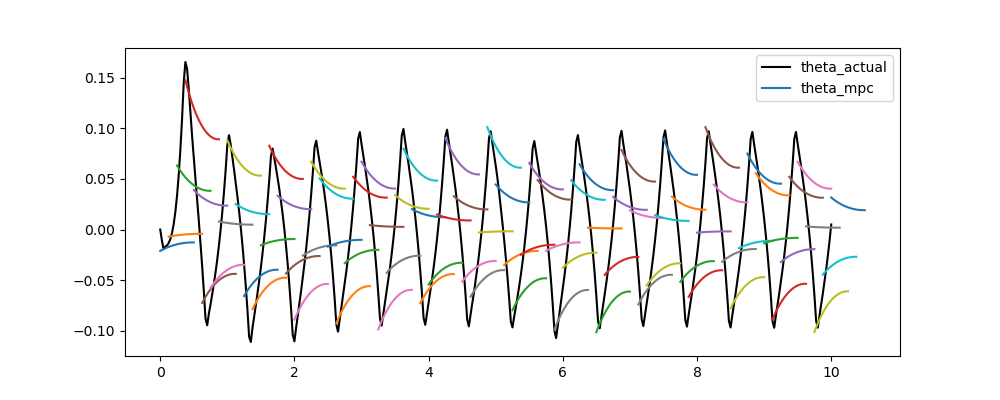

<IPython.core.display.Javascript object>


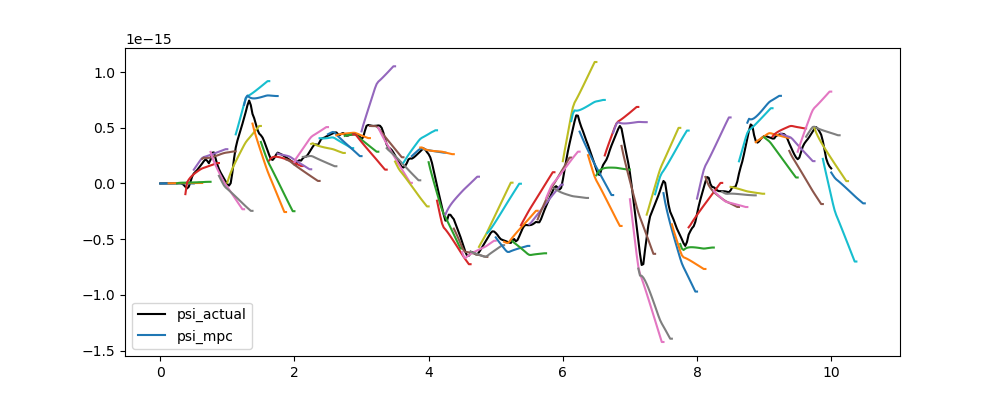

<IPython.core.display.Javascript object>


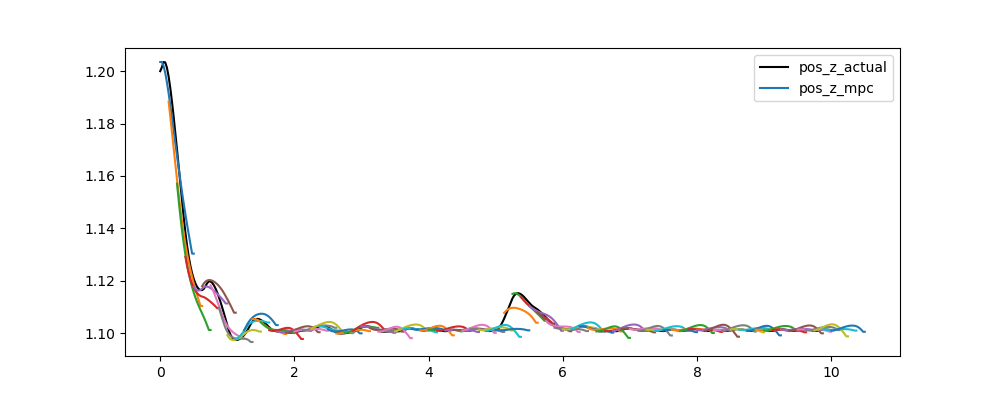

<IPython.core.display.Javascript object>


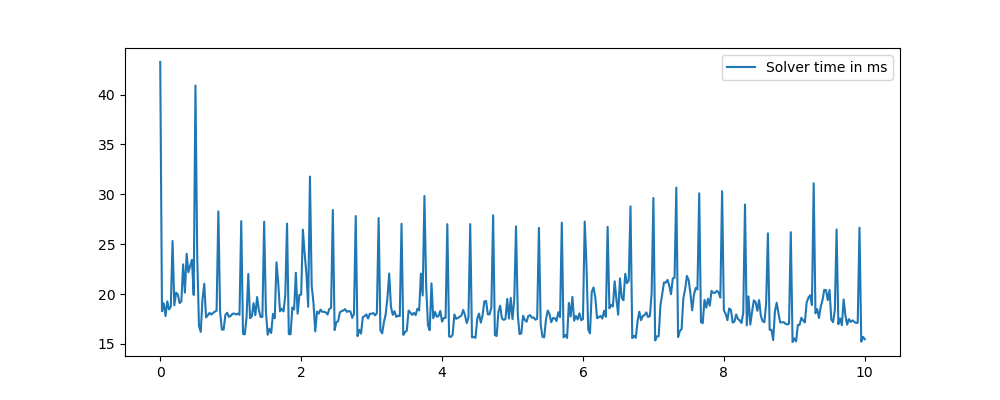

In [55]:
################################################################### MPC for full point mass model ######################################################################
from casadi import *

phi = SX.sym('phi') # Orientation Euler Angle 1 (X)
theta = SX.sym('theta') # Orientation Euler Angle 2 (Y)
psi = SX.sym('psi') # Orientation Euler Angle 3 (Z)

omega_x = SX.sym('omega_x')
omega_y = SX.sym('omega_y')
omega_z = SX.sym('omega_z')

p_x = SX.sym('p_x') # position X
p_y = SX.sym('p_y') # position Y
p_z = SX.sym('p_z') # position Z

v_x = SX.sym('v_x') # velocity X
v_y = SX.sym('v_y') # velocity Y
v_z = SX.sym('v_z') # velocity Z

g_constant = SX.sym('g') # gravity state / constant (is augmented to allow state space form), might be seperated again for readability

f_x_l = SX.sym('f_x_l') # Force in X on left foot
f_y_l = SX.sym('f_y_l') # Force in Y on left foot
f_z_l = SX.sym('f_z_l') # Force in Z on left foot

f_x_r = SX.sym('f_x_r') # Force in X on right foot
f_y_r = SX.sym('f_y_r') # Force in Y on right foot
f_z_r = SX.sym('f_z_r') # Force in Z on right foot

states = [phi, theta, psi, p_x, p_y, p_z, omega_x, omega_y, omega_z, v_x, v_y, v_z, g_constant]
n = len(states)

controls = [f_x_l, f_y_l, f_z_l, f_x_r, f_y_r, f_z_r]
m = len(controls)

dt = 1/40.0 # [s] (sampling time interval)
N = 20 # Prediction horizon Length

mu = 0.8

f_min_z = 0
f_max_z = 1000

# Testing:
Q = np.diag([2e+7, 1e+7, 1e+7, 1e+6, 2e+6, 1e+6, 1e+5, 2e+6, 1e+5, 1.5e+3, 4e+6, 4e+4, 0])
R = np.diag([1, 1, 1, 1, 1, 1])

# Baseline for tuning, works reasonably well with Gazebo 11.3 (Bullet engine) stepping in place with only torques
#Q = np.diag([2e+7, 1e+7, 1e+7, 1e+6, 2e+6, 1e+6, 1e+5, 2e+6, 1e+5, 1.5e+3, 4e+6, 4e+4, 0])
#R = np.diag([1, 1, 1, 1, 1, 1])

# Gazebo 11.3 (Bullet engine) stepping in place with all states stable (albeit some steady-state error)
#Q = np.diag([1e+6, 1e+6, 1e+5, 6e+6, 6e+7, 8e+6, 2e+3, 1.5e+3, 2e+3, 1.5e+3, 1e+3, 4e+3, 0])
#R = np.diag([1, 1, 1, 1, 1, 1])

r_y_left = r_y_right = 0
r_x_left = r_x_right = 0
r_z_left = r_z_right = 0

hip_offset = 0.15

t = 0

m_value = 30 # kg

swing_left = True
swing_right = False

# state is phi, theta, psi, p_x, p_y, p_z, omega_x, omega_y, omega_z, v_x, v_y, v_z, gravity constant

x_t = [0.0, 0.0, 0., 0, 0, 1.2, 0, 0, 0, 0, 0.0, 0, -9.81]
x_t = np.array(x_t).reshape(n,1)

simulation_time = 10 # [s]
iterations = 0

I_body = np.array([[0.208, 0., 0.],
                    [0., 0.639, 0.],
                    [0., 0., 0.584]]) # Inertia in the body frame (CoM of torso).

Ixx = I_body[0, 0]
Ixy = I_body[0, 1]
Ixz = I_body[0, 2]

Iyx = I_body[1, 0]
Iyy = I_body[1, 1]
Iyz = I_body[1, 2]

Izx = I_body[2, 0]
Izy = I_body[2, 1]
Izz = I_body[2, 2]

pos_x_desired = 0
pos_y_desired = 0.0
pos_z_desired = 1.1

vel_x_desired = 0.0
vel_y_desired = 0.0
vel_z_desired = 0.0

phi_desired = 0
theta_desired = 0
psi_desired = 0
omega_x_desired = 0
omega_y_desired = 0
omega_z_desired = 0

contact_swap_interval = int(1.0 / 3.0 / dt)
t_stance = contact_swap_interval * dt
gait_gain = 0.1

r_x_limit = 0.5

use_C_code = True # Determines whether or not C code for the NLP should be generated and used by the solver
delay_flag = True # If true, one sample delay is simulated as well as compensated

#############################################################################################################################################################

f_min_x = f_min_y = -mu * f_max_z
f_max_x = f_max_y = mu * f_max_z

U = SX.sym('U', m, N) # Control action matrix (that will be determined by the NLP solver)
X = SX.sym('X', n, N + 1) # State Matrix (that will also be determined by the NLP solver due to the chosen multiple-shooting method). The + 1 is for x0
P_rows = n
P_cols = 1 + N + N * m # last N * m for D matrix at each time step (used for contact constraint, passing D for every timestep allows to inform MPC about future contacts), REDUCE DIMENSIONALITY BY STATING CONTACT AS 1 OR 0!!!
print("P_cols:", P_cols)
P = SX.sym('P', P_rows, P_cols) # Parameter Matrix

objective_function = 0 # expression for the objective function

# lbx = lower bounds on optimization variable(s)
# ubx = upper bounds on optimization variable(s)
# lbg = lower bounds on constraints vector (should also be a vector), for equality constraints, just set lbg=ubg=k, where k is the constraint value
# ubg = upper bounds on constraints vector (should also be a vector)

lbx = []
ubx = []
lbg = []
ubg = []

g = [] # Constraint vector (both equality and inequality)

g += [X[:, 0] - P[:, 0]] # equality constraint x0 (chosen by solver) - x0 (input as parameter by user) = 0

lbg += [0] * n # n zeroes for equality constraints. These exist to ensure solver and actual initial state are the same.
ubg += [0] * n # n zeroes for equality constraints. These exist to ensure solver and actual initial state are the same.

# Lists containing various data from the entire simulation time, also / mainly used for plotting
state_history = [x_t]
reference_state_history = []
optimal_state_history = []
optimal_control_history = []
control_history = [np.array([[0], [0], [m_value*9.81/2], [0], [0], [m_value*9.81/2]]), np.array([[0], [0], [m_value*9.81/2], [0], [0], [m_value*9.81]]), np.array([[0], [0], [m_value*9.81/2], [0], [0], [m_value*9.81]])]
r_left_history = [np.array([[-hip_offset], [0], [-x_t[5, 0]]]), np.array([[-hip_offset], [0], [-x_t[5, 0]]]), np.array([[-hip_offset], [0], [-x_t[5, 0]]])]
r_right_history = [np.array([[hip_offset], [0], [-x_t[5, 0]]]), np.array([[hip_offset], [0], [-x_t[5, 0]]]), np.array([[hip_offset], [0], [-x_t[5, 0]]])]
left_foot_pos_world_history = []
right_foot_pos_world_history = []
t_history = []
solver_time_history = []
state_error_history = []
contact_matrix_history = []
discretization_r_y_history = []
state_full_control_applied_history = []
first_control_history = []
torque_history = []
orientation_predicted_history = []
vel_predicted_history = []
contact_history = []

phi_delay_compensation_history = []
theta_delay_compensation_history = []

P_param = np.zeros((P_rows, P_cols))

A_symbolic = SX.sym('A', n, n)
A_symbolic[:, :] = 0

B_symbolic = SX.sym('B', n, m)
B_symbolic[:,:] = 0

I_world_symbolic = SX.sym('I_world', 3, 3)

r_left_skew_symmetric_symbolic = SX.sym('r_left_skew_symmetric', 3, 3)
r_right_skew_symmetric_symbolic = SX.sym('r_right_skew_symmetric', 3, 3)

# Symbolic expression for discretization of B, see further down in notebook
integral_symbolic = SX.sym('integral', n, n)
integral_symbolic[:, :] = 0

for i in range(N):
    state = X[:, i] # Extract state at current time step
    next_state = X[:, i+1] # Extract state at next time step
    control = U[:, i] # Extract control input at current time step
    
    # Add the symbolic cost for each time step to the objective function based on different contact sets by using u_ref in P_param, updated at runtime
    u_ref = P[m:m+m, 1 + N + (i*m)]
    
    objective_function = objective_function + (next_state - P[:, i+1]).T @ Q @ (next_state - P[:, i+1]) + (control - u_ref).T @ R @ (control - u_ref) #+ 1e+8 * (next_state[1] - P[1, i+1])**4 # Extra cost that imitates a soft constraint for selected states
    
    H_body_world = np.array([[cos(state[2, 0])*cos(state[1, 0]), -sin(state[2, 0])*cos(state[1, 0]), sin(state[1, 0]), state[3, 0]], 
                             [sin(state[0, 0])*sin(state[1, 0])*cos(state[2, 0]) + sin(state[2, 0])*cos(state[0, 0]), -sin(state[0, 0])*sin(state[2, 0])*sin(state[1, 0]) + cos(state[0, 0])*cos(state[2, 0]), -sin(state[0, 0])*cos(state[1, 0]), state[4, 0]], 
                             [sin(state[0, 0])*sin(state[2, 0]) - sin(state[1, 0])*cos(state[0, 0])*cos(state[2, 0]), sin(state[0, 0])*cos(state[2, 0]) + sin(state[2, 0])*sin(state[1, 0])*cos(state[0, 0]), cos(state[0, 0])*cos(state[1, 0]), state[5, 0]],
                             [0, 0, 0, 1]])
    
    temp_I_world = np.array([[(sin(state[0, 0])*sin(state[2, 0]) + sin(state[1, 0])*cos(state[0, 0])*cos(state[2, 0]))*(Ixz*cos(state[2, 0])*cos(state[1, 0]) + Iyz*(sin(state[0, 0])*sin(state[1, 0])*cos(state[2, 0]) - sin(state[2, 0])*cos(state[0, 0])) + Izz*(sin(state[0, 0])*sin(state[2, 0]) + sin(state[1, 0])*cos(state[0, 0])*cos(state[2, 0]))) + (sin(state[0, 0])*sin(state[1, 0])*cos(state[2, 0]) - sin(state[2, 0])*cos(state[0, 0]))*(Ixy*(sin(state[0, 0])*sin(state[2, 0]) + sin(state[1, 0])*cos(state[0, 0])*cos(state[2, 0])) + Ixy*cos(state[2, 0])*cos(state[1, 0]) + Iyy*(sin(state[0, 0])*sin(state[1, 0])*cos(state[2, 0]) - sin(state[2, 0])*cos(state[0, 0]))) + (Ixx*cos(state[2, 0])*cos(state[1, 0]) + Iyx*(sin(state[0, 0])*sin(state[1, 0])*cos(state[2, 0]) - sin(state[2, 0])*cos(state[0, 0])) + Izx*(sin(state[0, 0])*sin(state[2, 0]) + sin(state[1, 0])*cos(state[0, 0])*cos(state[2, 0])))*cos(state[2, 0])*cos(state[1, 0]), (-sin(state[0, 0])*cos(state[2, 0]) + sin(state[2, 0])*sin(state[1, 0])*cos(state[0, 0]))*(Ixz*cos(state[2, 0])*cos(state[1, 0]) + Iyz*(sin(state[0, 0])*sin(state[1, 0])*cos(state[2, 0]) - sin(state[2, 0])*cos(state[0, 0])) + Izz*(sin(state[0, 0])*sin(state[2, 0]) + sin(state[1, 0])*cos(state[0, 0])*cos(state[2, 0]))) + (sin(state[0, 0])*sin(state[2, 0])*sin(state[1, 0]) + cos(state[0, 0])*cos(state[2, 0]))*(Ixy*(sin(state[0, 0])*sin(state[2, 0]) + sin(state[1, 0])*cos(state[0, 0])*cos(state[2, 0])) + Ixy*cos(state[2, 0])*cos(state[1, 0]) + Iyy*(sin(state[0, 0])*sin(state[1, 0])*cos(state[2, 0]) - sin(state[2, 0])*cos(state[0, 0]))) + (Ixx*cos(state[2, 0])*cos(state[1, 0]) + Iyx*(sin(state[0, 0])*sin(state[1, 0])*cos(state[2, 0]) - sin(state[2, 0])*cos(state[0, 0])) + Izx*(sin(state[0, 0])*sin(state[2, 0]) + sin(state[1, 0])*cos(state[0, 0])*cos(state[2, 0])))*sin(state[2, 0])*cos(state[1, 0]), (Ixy*(sin(state[0, 0])*sin(state[2, 0]) + sin(state[1, 0])*cos(state[0, 0])*cos(state[2, 0])) + Ixy*cos(state[2, 0])*cos(state[1, 0]) + Iyy*(sin(state[0, 0])*sin(state[1, 0])*cos(state[2, 0]) - sin(state[2, 0])*cos(state[0, 0])))*sin(state[0, 0])*cos(state[1, 0]) - (Ixx*cos(state[2, 0])*cos(state[1, 0]) + Iyx*(sin(state[0, 0])*sin(state[1, 0])*cos(state[2, 0]) - sin(state[2, 0])*cos(state[0, 0])) + Izx*(sin(state[0, 0])*sin(state[2, 0]) + sin(state[1, 0])*cos(state[0, 0])*cos(state[2, 0])))*sin(state[1, 0]) + (Ixz*cos(state[2, 0])*cos(state[1, 0]) + Iyz*(sin(state[0, 0])*sin(state[1, 0])*cos(state[2, 0]) - sin(state[2, 0])*cos(state[0, 0])) + Izz*(sin(state[0, 0])*sin(state[2, 0]) + sin(state[1, 0])*cos(state[0, 0])*cos(state[2, 0])))*cos(state[0, 0])*cos(state[1, 0])], [(sin(state[0, 0])*sin(state[2, 0]) + sin(state[1, 0])*cos(state[0, 0])*cos(state[2, 0]))*(Ixz*sin(state[2, 0])*cos(state[1, 0]) + Iyz*(sin(state[0, 0])*sin(state[2, 0])*sin(state[1, 0]) + cos(state[0, 0])*cos(state[2, 0])) + Izz*(-sin(state[0, 0])*cos(state[2, 0]) + sin(state[2, 0])*sin(state[1, 0])*cos(state[0, 0]))) + (sin(state[0, 0])*sin(state[1, 0])*cos(state[2, 0]) - sin(state[2, 0])*cos(state[0, 0]))*(Ixy*(-sin(state[0, 0])*cos(state[2, 0]) + sin(state[2, 0])*sin(state[1, 0])*cos(state[0, 0])) + Ixy*sin(state[2, 0])*cos(state[1, 0]) + Iyy*(sin(state[0, 0])*sin(state[2, 0])*sin(state[1, 0]) + cos(state[0, 0])*cos(state[2, 0]))) + (Ixx*sin(state[2, 0])*cos(state[1, 0]) + Iyx*(sin(state[0, 0])*sin(state[2, 0])*sin(state[1, 0]) + cos(state[0, 0])*cos(state[2, 0])) + Izx*(-sin(state[0, 0])*cos(state[2, 0]) + sin(state[2, 0])*sin(state[1, 0])*cos(state[0, 0])))*cos(state[2, 0])*cos(state[1, 0]), (-sin(state[0, 0])*cos(state[2, 0]) + sin(state[2, 0])*sin(state[1, 0])*cos(state[0, 0]))*(Ixz*sin(state[2, 0])*cos(state[1, 0]) + Iyz*(sin(state[0, 0])*sin(state[2, 0])*sin(state[1, 0]) + cos(state[0, 0])*cos(state[2, 0])) + Izz*(-sin(state[0, 0])*cos(state[2, 0]) + sin(state[2, 0])*sin(state[1, 0])*cos(state[0, 0]))) + (sin(state[0, 0])*sin(state[2, 0])*sin(state[1, 0]) + cos(state[0, 0])*cos(state[2, 0]))*(Ixy*(-sin(state[0, 0])*cos(state[2, 0]) + sin(state[2, 0])*sin(state[1, 0])*cos(state[0, 0])) + Ixy*sin(state[2, 0])*cos(state[1, 0]) + Iyy*(sin(state[0, 0])*sin(state[2, 0])*sin(state[1, 0]) + cos(state[0, 0])*cos(state[2, 0]))) + (Ixx*sin(state[2, 0])*cos(state[1, 0]) + Iyx*(sin(state[0, 0])*sin(state[2, 0])*sin(state[1, 0]) + cos(state[0, 0])*cos(state[2, 0])) + Izx*(-sin(state[0, 0])*cos(state[2, 0]) + sin(state[2, 0])*sin(state[1, 0])*cos(state[0, 0])))*sin(state[2, 0])*cos(state[1, 0]), (Ixy*(-sin(state[0, 0])*cos(state[2, 0]) + sin(state[2, 0])*sin(state[1, 0])*cos(state[0, 0])) + Ixy*sin(state[2, 0])*cos(state[1, 0]) + Iyy*(sin(state[0, 0])*sin(state[2, 0])*sin(state[1, 0]) + cos(state[0, 0])*cos(state[2, 0])))*sin(state[0, 0])*cos(state[1, 0]) - (Ixx*sin(state[2, 0])*cos(state[1, 0]) + Iyx*(sin(state[0, 0])*sin(state[2, 0])*sin(state[1, 0]) + cos(state[0, 0])*cos(state[2, 0])) + Izx*(-sin(state[0, 0])*cos(state[2, 0]) + sin(state[2, 0])*sin(state[1, 0])*cos(state[0, 0])))*sin(state[1, 0]) + (Ixz*sin(state[2, 0])*cos(state[1, 0]) + Iyz*(sin(state[0, 0])*sin(state[2, 0])*sin(state[1, 0]) + cos(state[0, 0])*cos(state[2, 0])) + Izz*(-sin(state[0, 0])*cos(state[2, 0]) + sin(state[2, 0])*sin(state[1, 0])*cos(state[0, 0])))*cos(state[0, 0])*cos(state[1, 0])], [(sin(state[0, 0])*sin(state[2, 0]) + sin(state[1, 0])*cos(state[0, 0])*cos(state[2, 0]))*(-Ixz*sin(state[1, 0]) + Iyz*sin(state[0, 0])*cos(state[1, 0]) + Izz*cos(state[0, 0])*cos(state[1, 0])) + (sin(state[0, 0])*sin(state[1, 0])*cos(state[2, 0]) - sin(state[2, 0])*cos(state[0, 0]))*(-Ixy*sin(state[1, 0]) + Ixy*cos(state[0, 0])*cos(state[1, 0]) + Iyy*sin(state[0, 0])*cos(state[1, 0])) + (-Ixx*sin(state[1, 0]) + Iyx*sin(state[0, 0])*cos(state[1, 0]) + Izx*cos(state[0, 0])*cos(state[1, 0]))*cos(state[2, 0])*cos(state[1, 0]), (-sin(state[0, 0])*cos(state[2, 0]) + sin(state[2, 0])*sin(state[1, 0])*cos(state[0, 0]))*(-Ixz*sin(state[1, 0]) + Iyz*sin(state[0, 0])*cos(state[1, 0]) + Izz*cos(state[0, 0])*cos(state[1, 0])) + (sin(state[0, 0])*sin(state[2, 0])*sin(state[1, 0]) + cos(state[0, 0])*cos(state[2, 0]))*(-Ixy*sin(state[1, 0]) + Ixy*cos(state[0, 0])*cos(state[1, 0]) + Iyy*sin(state[0, 0])*cos(state[1, 0])) + (-Ixx*sin(state[1, 0]) + Iyx*sin(state[0, 0])*cos(state[1, 0]) + Izx*cos(state[0, 0])*cos(state[1, 0]))*sin(state[2, 0])*cos(state[1, 0]), -(-Ixx*sin(state[1, 0]) + Iyx*sin(state[0, 0])*cos(state[1, 0]) + Izx*cos(state[0, 0])*cos(state[1, 0]))*sin(state[1, 0]) + (-Ixy*sin(state[1, 0]) + Ixy*cos(state[0, 0])*cos(state[1, 0]) + Iyy*sin(state[0, 0])*cos(state[1, 0]))*sin(state[0, 0])*cos(state[1, 0]) + (-Ixz*sin(state[1, 0]) + Iyz*sin(state[0, 0])*cos(state[1, 0]) + Izz*cos(state[0, 0])*cos(state[1, 0]))*cos(state[0, 0])*cos(state[1, 0])]])
    
    for row in range(3):
        for col in range(3):
            I_world_symbolic[row, col] = temp_I_world[row, col]
            
    # See cells below for derivation
    integral_symbolic[:, :] = np.diag([dt] * n)
    integral_symbolic[0, 6] = (dt**2 * cos(state[0, 0])) / (2 * cos(state[1, 0]))
    integral_symbolic[1, 6] = (dt**2 * sin(state[2, 0])) / 2
    integral_symbolic[2, 6] = (dt**2 * cos(state[2, 0]) * tan(state[1, 0])) / 2
    integral_symbolic[0, 7] = (dt**2 * sin(state[2, 0])) / (2 * cos(state[1, 0]))
    integral_symbolic[1, 7] = (dt**2 * cos(state[2, 0])) / 2
    integral_symbolic[2, 7] = (dt**2 * sin(state[2, 0]) * tan((state[1, 0]))) / 2
    integral_symbolic[2, 8] = integral_symbolic[3, 9] = integral_symbolic[4, 10] = integral_symbolic[5, 11] = dt**2 / 2
    integral_symbolic[5, 12] = dt**3 / 6
    integral_symbolic[11, 12] = dt**2 / 2
    
    I_world_symbolic_inverse = solve(I_world_symbolic, SX.eye(I_world_symbolic.size1()))
    
    hip_pos_world_left = (H_body_world @ np.array([[-hip_offset], [0], [0], [1]]).copy())[0:3]
    hip_pos_world_right = (H_body_world @ np.array([[hip_offset], [0], [0], [1]]).copy())[0:3]
    
    foot_pos_world_desired_left = hip_pos_world_left + (t_stance / 2.0) * state[9:12] + gait_gain * (state[9:12] - P[9:12, i]) + 0.5 * sqrt(fabs(state[5, 0]) / 9.81) * cross(state[9:12], P[6:9])
    foot_pos_world_desired_right = hip_pos_world_right + (t_stance / 2.0) * state[9:12] + gait_gain * (state[9:12] - P[9:12, i]) + 0.5 * sqrt(fabs(state[5, 0]) / 9.81) * cross(state[9:12], P[6:9])
    
    r_x_left = foot_pos_world_desired_left[0, 0] - state[3, 0]
    r_y_left = foot_pos_world_desired_left[1, 0] - state[4, 0]
    r_z_left = -state[5, 0]
    
    r_x_right = foot_pos_world_desired_right[0, 0] - state[3, 0]
    r_y_right = foot_pos_world_desired_right[1, 0] - state[4, 0]
    r_z_right = -state[5, 0]
    
    r_left_skew_symmetric_symbolic[0, 0] = 0
    r_left_skew_symmetric_symbolic[1, 0] = r_z_left
    r_left_skew_symmetric_symbolic[2, 0] = -r_y_left
    
    r_left_skew_symmetric_symbolic[0, 1] = -r_z_left
    r_left_skew_symmetric_symbolic[1, 1] = 0
    r_left_skew_symmetric_symbolic[2, 1] = r_x_left
    
    r_left_skew_symmetric_symbolic[0, 2] = r_y_left
    r_left_skew_symmetric_symbolic[1, 2] = -r_x_left
    r_left_skew_symmetric_symbolic[2, 2] = 0
    
    r_right_skew_symmetric_symbolic[0, 0] = 0
    r_right_skew_symmetric_symbolic[1, 0] = r_z_right
    r_right_skew_symmetric_symbolic[2, 0] = -r_y_right
    
    r_right_skew_symmetric_symbolic[0, 1] = -r_z_right
    r_right_skew_symmetric_symbolic[1, 1] = 0
    r_right_skew_symmetric_symbolic[2, 1] = r_x_right
    
    r_right_skew_symmetric_symbolic[0, 2] = r_y_right
    r_right_skew_symmetric_symbolic[1, 2] = -r_x_right
    r_right_skew_symmetric_symbolic[2, 2] = 0
    
    
    A_symbolic[:, :] = np.identity(13)
    A_symbolic[0, 6] = (dt * cos(state[0, 0])) / cos(state[1, 0])
    A_symbolic[1, 6] = dt * sin(state[2, 0])
    A_symbolic[2, 6] = dt * cos(state[2, 0]) * tan(state[1, 0])
    A_symbolic[0, 7] = (dt * sin(state[2, 0])) / cos(state[1, 0])
    A_symbolic[1, 7] = dt * cos(state[2, 0])
    A_symbolic[2, 7] = dt * sin(state[2, 0]) * tan(state[1, 0])
    A_symbolic[2, 8] = A_symbolic[3, 9] = A_symbolic[4, 10] = A_symbolic[5, 11] = dt
    A_symbolic[5, 12] = dt**2 / 2
    A_symbolic[11, 12] = dt
    
    A_d_t = A_symbolic
    
    B_symbolic[6:9, 0:3] = I_world_symbolic_inverse @ r_left_skew_symmetric_symbolic
    B_symbolic[6:9, 3:6] = I_world_symbolic_inverse @ r_right_skew_symmetric_symbolic
    
    B_symbolic[9:12, 0:3] = np.diag([1/m_value, 1/m_value, 1/m_value])
    B_symbolic[9:12, 3:6] = np.diag([1/m_value, 1/m_value, 1/m_value])
    
    B_d_t = integral_symbolic @ B_symbolic
    next_state_simulation = A_d_t @ state + B_d_t @ control # Calculate state at next time step
    
    # This is the equality constraint required for multiple shooting, making the solver respect the system dynamics
    g += [next_state - next_state_simulation]
    
    lbg += [0] * n # n zeroes for equality constraints enforcing system dynamics on every state
    ubg += [0] * n # n zeroes for equality constraints enforcing system dynamics on every state

for i in range(N): # Contact constraints D * u = 0
    g += [P[:m, 1 + N + (i*m):1 + N + (i*m) + m] @ U[:, i]]
    lbg += [0] * m
    ubg += [0] * m

for i in range(N): # Friction cone constraints.
    
    # Get symbolic forces
    f_x_left = U[0, i]
    f_y_left = U[1, i]
    f_z_left = U[2, i]

    f_x_right = U[3, i]
    f_y_right = U[4, i]
    f_z_right = U[5, i]

    # -mu * f_z < f_x
    g += [-mu * f_z_left - f_x_left]
    lbg += [-inf]
    ubg += [0]

    # f_x < mu * f_z
    g += [f_x_left - mu * f_z_left]
    lbg += [-inf]
    ubg += [0]

    # -mu * f_z < f_y
    g += [-mu * f_z_left - f_y_left]
    lbg += [-inf]
    ubg += [0]

    # f_y < mu * f_z
    g += [f_y_left - mu * f_z_left]
    lbg += [-inf]
    ubg += [0]

    # -mu * f_z < f_x
    g += [-mu * f_z_right - f_x_right]
    lbg += [-inf]
    ubg += [0]

    # f_x < mu * f_z
    g += [f_x_right - mu * f_z_right]
    lbg += [-inf]
    ubg += [0]

    # -mu * f_z < f_y
    g += [-mu * f_z_right - f_y_right]
    lbg += [-inf]
    ubg += [0]

    # f_y < mu * f_z
    g += [f_y_right - mu * f_z_right]
    lbg += [-inf]
    ubg += [0]


optimization_variables = [X.reshape((n * (N+1), 1)), U.reshape((m * N, 1))]
nlp = {'x':vertcat(*optimization_variables), 'f':objective_function, 'g':vertcat(*g), 'p':P}

opts = {}
opts["print_time"] = 0
opts["expand"] = False
opts['ipopt'] = {"max_iter":60, "print_level":0, "acceptable_tol":1e-7, "acceptable_obj_change_tol":1e-5, "linear_solver":"mumps"}

solver = nlpsol('solver', 'ipopt', nlp, opts);

# Initialization values for solver
U_t = np.zeros((m * N, 1))
X_t = np.matlib.repmat(np.array(x_t).reshape(n,1), N+1, 1)



for i in range(n * (N+1)):
    lbx += [-inf]
    ubx += [inf]

'''
max_pos_z = 1.3

for i in range(N+1):
    lbx[n*i+5] = 0
    ubx[n*i+5] = max_pos_z
'''

for i in range(N): # Should be possible to reduce the number of constraints if needed since the x and y forces are already limited by the friction constraint
    lbx += [-inf, -inf, f_min_z, -inf, -inf, f_min_z]
    ubx += [inf, inf, f_max_z, inf, inf, f_max_z]
            
print("Minimum possible Force in X and Y direction:", -mu * f_max_z)
print("Maximum possible Force in X and Y direction:", mu * f_max_z)

solver.generate_dependencies('nlp.c')

if use_C_code:
    
    print("Compiling C Code for solver...")
    
    solver.generate_dependencies('nlp.c')
    os.system("gcc -O2 -fPIC -shared nlp.c -o ./nlp.so")
    solver = nlpsol("solver", "ipopt", "./nlp.so", opts)
    
    print("Finished compiling.")

print("Entering main MPC loop...")

for t in tqdm(np.arange(0, simulation_time+dt, dt)):
    
    #if vel_y_desired < 0.3:
    #    vel_y_desired += 0.005
    
    #if omega_z_desired < 0.3:
    #    omega_z_desired += 0.005
    
    if delay_flag:
        
        r_x_left_prev = r_x_left
        r_x_right_prev = r_x_right

        r_y_left_prev = r_y_left
        r_y_right_prev = r_y_right

        r_z_left_prev = r_z_left
        r_z_right_prev = r_z_right

        # Step the model one timestep to account for delay caused by solver time and comms
        phi_t = x_t[0, 0]
        theta_t = x_t[1, 0]
        psi_t = x_t[2, 0]

        r_x_left = r_left_history[-1][0]
        r_x_right = r_right_history[-1][0]

        r_y_left = r_left_history[-1][1]
        r_y_right = r_right_history[-1][1]

        r_z_left = r_left_history[-1][2]
        r_z_right = r_right_history[-1][2]

        I_world = np.array([[(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t))*(Ixz*cos(psi_t)*cos(theta_t) + Iyz*(sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t)) + Izz*(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t))) + (sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t))*(Ixy*(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t)) + Ixy*cos(psi_t)*cos(theta_t) + Iyy*(sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t))) + (Ixx*cos(psi_t)*cos(theta_t) + Iyx*(sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t)) + Izx*(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t)))*cos(psi_t)*cos(theta_t), (-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t))*(Ixz*cos(psi_t)*cos(theta_t) + Iyz*(sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t)) + Izz*(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t))) + (sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t))*(Ixy*(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t)) + Ixy*cos(psi_t)*cos(theta_t) + Iyy*(sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t))) + (Ixx*cos(psi_t)*cos(theta_t) + Iyx*(sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t)) + Izx*(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t)))*sin(psi_t)*cos(theta_t), (Ixy*(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t)) + Ixy*cos(psi_t)*cos(theta_t) + Iyy*(sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t)))*sin(phi_t)*cos(theta_t) - (Ixx*cos(psi_t)*cos(theta_t) + Iyx*(sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t)) + Izx*(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t)))*sin(theta_t) + (Ixz*cos(psi_t)*cos(theta_t) + Iyz*(sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t)) + Izz*(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t)))*cos(phi_t)*cos(theta_t)], [(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t))*(Ixz*sin(psi_t)*cos(theta_t) + Iyz*(sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t)) + Izz*(-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t))) + (sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t))*(Ixy*(-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t)) + Ixy*sin(psi_t)*cos(theta_t) + Iyy*(sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t))) + (Ixx*sin(psi_t)*cos(theta_t) + Iyx*(sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t)) + Izx*(-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t)))*cos(psi_t)*cos(theta_t), (-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t))*(Ixz*sin(psi_t)*cos(theta_t) + Iyz*(sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t)) + Izz*(-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t))) + (sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t))*(Ixy*(-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t)) + Ixy*sin(psi_t)*cos(theta_t) + Iyy*(sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t))) + (Ixx*sin(psi_t)*cos(theta_t) + Iyx*(sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t)) + Izx*(-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t)))*sin(psi_t)*cos(theta_t), (Ixy*(-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t)) + Ixy*sin(psi_t)*cos(theta_t) + Iyy*(sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t)))*sin(phi_t)*cos(theta_t) - (Ixx*sin(psi_t)*cos(theta_t) + Iyx*(sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t)) + Izx*(-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t)))*sin(theta_t) + (Ixz*sin(psi_t)*cos(theta_t) + Iyz*(sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t)) + Izz*(-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t)))*cos(phi_t)*cos(theta_t)], [(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t))*(-Ixz*sin(theta_t) + Iyz*sin(phi_t)*cos(theta_t) + Izz*cos(phi_t)*cos(theta_t)) + (sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t))*(-Ixy*sin(theta_t) + Ixy*cos(phi_t)*cos(theta_t) + Iyy*sin(phi_t)*cos(theta_t)) + (-Ixx*sin(theta_t) + Iyx*sin(phi_t)*cos(theta_t) + Izx*cos(phi_t)*cos(theta_t))*cos(psi_t)*cos(theta_t), (-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t))*(-Ixz*sin(theta_t) + Iyz*sin(phi_t)*cos(theta_t) + Izz*cos(phi_t)*cos(theta_t)) + (sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t))*(-Ixy*sin(theta_t) + Ixy*cos(phi_t)*cos(theta_t) + Iyy*sin(phi_t)*cos(theta_t)) + (-Ixx*sin(theta_t) + Iyx*sin(phi_t)*cos(theta_t) + Izx*cos(phi_t)*cos(theta_t))*sin(psi_t)*cos(theta_t), -(-Ixx*sin(theta_t) + Iyx*sin(phi_t)*cos(theta_t) + Izx*cos(phi_t)*cos(theta_t))*sin(theta_t) + (-Ixy*sin(theta_t) + Ixy*cos(phi_t)*cos(theta_t) + Iyy*sin(phi_t)*cos(theta_t))*sin(phi_t)*cos(theta_t) + (-Ixz*sin(theta_t) + Iyz*sin(phi_t)*cos(theta_t) + Izz*cos(phi_t)*cos(theta_t))*cos(phi_t)*cos(theta_t)]])
        
        r_left_skew_symmetric = np.array([[0, float(-r_z_left), float(r_y_left)],
                                          [float(r_z_left), 0, float(-r_x_left)],
                                          [float(-r_y_left), float(r_x_left), 0]])

        r_right_skew_symmetric = np.array([[0, float(-r_z_right), float(r_y_right)],
                                           [float(r_z_right), 0, float(-r_x_right)],
                                           [float(-r_y_right), float(r_x_right), 0]])

        A_c = np.array([[0, 0, 0, 0, 0, 0, math.cos(psi_t) / math.cos(theta_t), math.sin(psi_t) / math.cos(theta_t), 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, -math.sin(psi_t), math.cos(psi_t), 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, math.cos(psi_t) * math.tan(theta_t), math.sin(psi_t) * math.tan(theta_t), 1, 0, 0, 0, 0],

                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],

                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],

                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

        B_c = np.block([[0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0],
                            [np.linalg.inv(I_world) @ r_left_skew_symmetric, np.linalg.inv(I_world) @ r_right_skew_symmetric],
                            [1/m_value, 0, 0, 1/m_value, 0, 0],
                            [0, 1/m_value, 0, 0, 1/m_value, 0],
                            [0, 0, 1/m_value, 0, 0, 1/m_value],
                            [0, 0, 0, 0, 0, 0]])

        A_d, B_d = discretize_ss(A_c, B_c, dt)

        P_param[:, 0] = (A_d @ np.array(x_t).reshape(n,1) + B_d @ control_history[-1]).reshape(n).copy()
        
        r_x_left = r_x_left_prev
        r_x_right = r_x_right_prev

        r_y_left = r_y_left_prev
        r_y_right = r_y_right_prev

        r_z_left = r_z_left_prev
        r_z_right = r_z_right_prev
    else:
        P_param[:, 0] = x_t.reshape(n).copy()
    
    phi_delay_compensation_history.append(P_param[0, 0])
    theta_delay_compensation_history.append(P_param[1, 0])
    
    if iterations % contact_swap_interval == 0:
        swing_left = not swing_left
        swing_right = not swing_right
    
    swing_left_temp = swing_left
    swing_right_temp = swing_right
    
    for k in range(N):
        if (iterations+k) % contact_swap_interval == 0 and k != 0:
            swing_left_temp = not swing_left_temp
            swing_right_temp = not swing_right_temp
            
        D_current_temp = np.array([[int(swing_left_temp == True), 0, 0, 0, 0, 0],
                                  [0, int(swing_left_temp == True), 0, 0, 0, 0],
                                  [0, 0, int(swing_left_temp == True), 0, 0, 0],
                                  [0, 0, 0, int(swing_right_temp == True), 0, 0],
                                  [0, 0, 0, 0, int(swing_right_temp == True), 0],
                                  [0, 0, 0, 0, 0, int(swing_right_temp == True)]]) # Swing = no contact (and thus 1 * [any force] == 0 must mean [any force[] is 0)
        
        P_param[:m, 1+N+(k*m):1+N+(k*m)+m] = D_current_temp.copy()
        
        if P_param[:m, 1 + N + k*m: 1 + N + k*m + m][0, 0] == 1 and P_param[:m, 1 + N + k*m: 1 + N + k*m + m][3, 3] == 1: # No feet in contact
            P_param[m:m+m, 1 + N + (k*m)] = np.array([0, 0, 0, 0, 0, 0]).copy()
            #print("No feet in contact")
        elif P_param[:m, 1 + N + k*m: 1 + N + k*m + m][0, 0] == 1 and P_param[:m, 1 + N + k*m: 1 + N + k*m + m][3, 3] == 0: # Right foot in contact
            P_param[m:m+m, 1 + N + (k*m)] = np.array([0, 0, 0, 0, 0, m_value * 9.81]).copy()
            #print("Right foot in contact")
        elif  P_param[:m, 1 + N + k*m: 1 + N + k*m + m][0, 0] == 0 and P_param[:m, 1 + N + k*m: 1 + N + k*m + m][3, 3] == 1: # Left foot in contact
            P_param[m:m+m, 1 + N + (k*m)] = np.array([0, 0, m_value * 9.81, 0, 0, 0]).copy()
            #print("Left foot in contact")
        if  P_param[:m, 1 + N + k*m: 1 + N + k*m + m][0, 0] == 0 and P_param[:m, 1 + N + k*m: 1 + N + k*m + m][3, 3] == 0: # Both feet in contact
            P_param[m:m+m, 1 + N + (k*m)] = np.array([0, 0, (m_value * 9.81) / 2, 0, 0, (m_value * 9.81) / 2]).copy()
            #print("Both feet in contact")
    
    contact_history.append([P_param[:m, 1 + N:1 + N + m][0, 0].copy(), P_param[:m, 1 + N:1 + N + m][3, 3]].copy())
    
    if iterations % contact_swap_interval == 0:
        
        H_body_world = np.array([[cos(P_param[2, 0])*cos(P_param[1, 0]), -sin(P_param[2, 0])*cos(P_param[1, 0]), sin(P_param[1, 0]), P_param[3, 0]], 
                                 [sin(P_param[0, 0])*sin(P_param[1, 0])*cos(P_param[2, 0]) + sin(P_param[2, 0])*cos(P_param[0, 0]), -sin(P_param[0, 0])*sin(P_param[2, 0])*sin(P_param[1, 0]) + cos(P_param[0, 0])*cos(P_param[2, 0]), -sin(P_param[0, 0])*cos(P_param[1, 0]), P_param[4, 0]], 
                                 [sin(P_param[0, 0])*sin(P_param[2, 0]) - sin(P_param[1, 0])*cos(P_param[0, 0])*cos(P_param[2, 0]), sin(P_param[0, 0])*cos(P_param[2, 0]) + sin(P_param[2, 0])*sin(P_param[1, 0])*cos(P_param[0, 0]), cos(P_param[0, 0])*cos(P_param[1, 0]), P_param[5, 0]],
                                 [0, 0, 0, 1]])
        
        #H_body_world = np.array([[cos(P_param[2, 0]), -sin(P_param[2, 0]), 0, P_param[3, 0]], 
        #                         [sin(P_param[2, 0]), cos(P_param[2, 0]), 0, P_param[4, 0]], 
        #                         [0, 0, 1, P_param[5, 0]],
        #                         [0, 0, 0, 1]])
        
        adjusted_pos_vector_left = (H_body_world @ np.array([[-hip_offset], [0], [0], [1]]))[0:3]
        adjusted_pos_vector_right = (H_body_world @ np.array([[hip_offset], [0], [0], [1]]))[0:3]
        
        left_foot_pos_world = adjusted_pos_vector_left + (t_stance/2) * P_param[9:12] + gait_gain * (P_param[9:12] - np.array([[vel_x_desired], [vel_y_desired], [vel_z_desired]])) + 0.5 * math.sqrt(abs(P_param[5, 0]) / 9.81) * (np.cross([P_param[9, 0], P_param[10, 0], P_param[11, 0]], [omega_x_desired, omega_y_desired, omega_z_desired]).reshape(3,1))
        right_foot_pos_world = adjusted_pos_vector_right + (t_stance/2) * P_param[9:12] + gait_gain * (P_param[9:12] - np.array([[vel_x_desired], [vel_y_desired], [vel_z_desired]])) + 0.5 * math.sqrt(abs(P_param[5, 0]) / 9.81) * (np.cross([P_param[9, 0], P_param[10, 0], P_param[11, 0]], [omega_x_desired, omega_y_desired, omega_z_desired]).reshape(3,1))
        
        left_foot_pos_body = (np.linalg.inv(H_body_world) @ np.array([[left_foot_pos_world[0, 0]], [left_foot_pos_world[1, 0]], [left_foot_pos_world[2, 0]], [1]]))[0:3]
        right_foot_pos_body = (np.linalg.inv(H_body_world) @ np.array([[right_foot_pos_world[0, 0]], [right_foot_pos_world[1, 0]], [right_foot_pos_world[2, 0]], [1]]))[0:3]
        
        if left_foot_pos_body[0, 0] > r_x_limit - hip_offset:
            left_foot_pos_body[0, 0] = r_x_limit - hip_offset
            left_foot_pos_world = (H_body_world @ np.array([[left_foot_pos_body[0, 0]], [left_foot_pos_body[1, 0]], [left_foot_pos_body[2, 0]], [1]]))[0:3]
            
        elif left_foot_pos_body[0, 0] < -r_x_limit - hip_offset:
            left_foot_pos_body[0, 0] = -r_x_limit - hip_offset
            left_foot_pos_world = (H_body_world @ np.array([[left_foot_pos_body[0, 0]], [left_foot_pos_body[1, 0]], [left_foot_pos_body[2, 0]], [1]]))[0:3]

        if right_foot_pos_body[0, 0] > r_x_limit + hip_offset:
            right_foot_pos_body[0, 0] = r_x_limit + hip_offset
            right_foot_pos_world = (H_body_world @ np.array([[right_foot_pos_body[0, 0]], [right_foot_pos_body[1, 0]], [right_foot_pos_body[2, 0]], [1]]))[0:3]
            
        elif right_foot_pos_body[0, 0] < -r_x_limit + hip_offset:
            right_foot_pos_body[0, 0] = -r_x_limit + hip_offset
            right_foot_pos_world = (H_body_world @ np.array([[right_foot_pos_body[0, 0]], [right_foot_pos_body[1, 0]], [right_foot_pos_body[2, 0]], [1]]))[0:3]
    
    r_x_left = left_foot_pos_world[0, 0] - P_param[3, 0]
    r_x_right = right_foot_pos_world[0, 0] - P_param[3, 0]
    
    r_y_left = left_foot_pos_world[1, 0] - P_param[4, 0]
    r_y_right = right_foot_pos_world[1, 0] - P_param[4, 0]
    
    r_z_left = -P_param[5, 0]
    r_z_right = -P_param[5, 0]
    
    r_left_history.append([r_x_left, r_y_left, r_z_left])
    r_right_history.append([r_x_right, r_y_right, r_z_right])
    
    x_ref = np.zeros((n, N))
    
    pos_x_temp = pos_x_desired
    pos_y_temp = pos_y_desired
    vel_y_desired_temp = vel_y_desired# - 0.005
    pos_z_temp = pos_z_desired
    
    phi_temp = phi_desired
    theta_temp = theta_desired
    psi_temp = psi_desired
    omega_z_desired_temp = omega_z_desired #- 0.005
    
    for i in range(N):
        #if vel_y_desired_temp < 0.3:
        #    vel_y_desired_temp += 0.005
        
        #if omega_z_desired_temp < 0.3:
        #    omega_z_desired_temp += 0.005
        
        pos_x_temp += vel_x_desired * dt
        pos_y_temp += vel_y_desired_temp * dt
        pos_z_temp += vel_z_desired * dt
        
        phi_temp += omega_x_desired * dt
        theta_temp += omega_y_desired * dt
        psi_temp += omega_z_desired_temp * dt
        
        x_ref[:, i] = np.array([phi_temp, theta_temp, psi_temp, pos_x_temp, pos_y_temp, pos_z_temp, omega_x_desired, omega_y_desired, omega_z_desired_temp, vel_x_desired, vel_y_desired_temp, vel_z_desired, -9.81]).reshape(n)
        
    pos_x_desired += vel_x_desired * dt
    pos_y_desired += vel_y_desired * dt
    pos_z_desired += vel_z_desired * dt
    
    phi_desired += omega_x_desired * dt
    theta_desired += omega_y_desired * dt
    psi_desired += omega_z_desired * dt

    P_param[:, 1:1 + N] = x_ref.copy()

    reference_state_history.append(x_ref[:, 0].reshape(n,1).copy()) # or -1
    
    state_error_history.append(x_ref[:, 0].copy().reshape(n,1) - x_t.copy())
    
    left_foot_pos_world_history.append([r_x_left + x_t[3], r_y_left + x_t[4], r_z_left + x_t[5]])
    right_foot_pos_world_history.append([r_x_right + x_t[3], r_y_right + x_t[4], r_z_right + x_t[5]])
    
    x0_solver = vertcat(*[X_t, U_t])
    
    start_time = time.time()
    sol = solver(x0=x0_solver, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg, p=DM(P_param))
    end_time = time.time()
    
    solver_time_history.append((end_time - start_time) * 1000)
    
    t_history.append(t)
    
    u_t = sol['x'][n * (N+1) :n * (N+1) + m]
    control_history.append(np.array(u_t).reshape(m,1).copy())
    
    # Simulate the actual model with a delay by using the previous values for r and u
    phi_t = x_t[0, 0]
    theta_t = x_t[1, 0]
    psi_t = x_t[2, 0]
    
    if delay_flag:
    
        r_x_left = r_left_history[-2][0]
        r_x_right = r_right_history[-2][0]

        r_y_left = r_left_history[-2][1]
        r_y_right = r_right_history[-2][1]

        r_z_left = r_left_history[-2][2]
        r_z_right = r_right_history[-2][2]
    else:
        r_x_left = r_left_history[-1][0]
        r_x_right = r_right_history[-1][0]

        r_y_left = r_left_history[-1][1]
        r_y_right = r_right_history[-1][1]

        r_z_left = r_left_history[-1][2]
        r_z_right = r_right_history[-1][2]
    
    I_world = np.array([[(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t))*(Ixz*cos(psi_t)*cos(theta_t) + Iyz*(sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t)) + Izz*(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t))) + (sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t))*(Ixy*(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t)) + Ixy*cos(psi_t)*cos(theta_t) + Iyy*(sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t))) + (Ixx*cos(psi_t)*cos(theta_t) + Iyx*(sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t)) + Izx*(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t)))*cos(psi_t)*cos(theta_t), (-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t))*(Ixz*cos(psi_t)*cos(theta_t) + Iyz*(sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t)) + Izz*(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t))) + (sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t))*(Ixy*(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t)) + Ixy*cos(psi_t)*cos(theta_t) + Iyy*(sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t))) + (Ixx*cos(psi_t)*cos(theta_t) + Iyx*(sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t)) + Izx*(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t)))*sin(psi_t)*cos(theta_t), (Ixy*(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t)) + Ixy*cos(psi_t)*cos(theta_t) + Iyy*(sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t)))*sin(phi_t)*cos(theta_t) - (Ixx*cos(psi_t)*cos(theta_t) + Iyx*(sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t)) + Izx*(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t)))*sin(theta_t) + (Ixz*cos(psi_t)*cos(theta_t) + Iyz*(sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t)) + Izz*(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t)))*cos(phi_t)*cos(theta_t)], [(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t))*(Ixz*sin(psi_t)*cos(theta_t) + Iyz*(sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t)) + Izz*(-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t))) + (sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t))*(Ixy*(-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t)) + Ixy*sin(psi_t)*cos(theta_t) + Iyy*(sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t))) + (Ixx*sin(psi_t)*cos(theta_t) + Iyx*(sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t)) + Izx*(-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t)))*cos(psi_t)*cos(theta_t), (-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t))*(Ixz*sin(psi_t)*cos(theta_t) + Iyz*(sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t)) + Izz*(-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t))) + (sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t))*(Ixy*(-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t)) + Ixy*sin(psi_t)*cos(theta_t) + Iyy*(sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t))) + (Ixx*sin(psi_t)*cos(theta_t) + Iyx*(sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t)) + Izx*(-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t)))*sin(psi_t)*cos(theta_t), (Ixy*(-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t)) + Ixy*sin(psi_t)*cos(theta_t) + Iyy*(sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t)))*sin(phi_t)*cos(theta_t) - (Ixx*sin(psi_t)*cos(theta_t) + Iyx*(sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t)) + Izx*(-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t)))*sin(theta_t) + (Ixz*sin(psi_t)*cos(theta_t) + Iyz*(sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t)) + Izz*(-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t)))*cos(phi_t)*cos(theta_t)], [(sin(phi_t)*sin(psi_t) + sin(theta_t)*cos(phi_t)*cos(psi_t))*(-Ixz*sin(theta_t) + Iyz*sin(phi_t)*cos(theta_t) + Izz*cos(phi_t)*cos(theta_t)) + (sin(phi_t)*sin(theta_t)*cos(psi_t) - sin(psi_t)*cos(phi_t))*(-Ixy*sin(theta_t) + Ixy*cos(phi_t)*cos(theta_t) + Iyy*sin(phi_t)*cos(theta_t)) + (-Ixx*sin(theta_t) + Iyx*sin(phi_t)*cos(theta_t) + Izx*cos(phi_t)*cos(theta_t))*cos(psi_t)*cos(theta_t), (-sin(phi_t)*cos(psi_t) + sin(psi_t)*sin(theta_t)*cos(phi_t))*(-Ixz*sin(theta_t) + Iyz*sin(phi_t)*cos(theta_t) + Izz*cos(phi_t)*cos(theta_t)) + (sin(phi_t)*sin(psi_t)*sin(theta_t) + cos(phi_t)*cos(psi_t))*(-Ixy*sin(theta_t) + Ixy*cos(phi_t)*cos(theta_t) + Iyy*sin(phi_t)*cos(theta_t)) + (-Ixx*sin(theta_t) + Iyx*sin(phi_t)*cos(theta_t) + Izx*cos(phi_t)*cos(theta_t))*sin(psi_t)*cos(theta_t), -(-Ixx*sin(theta_t) + Iyx*sin(phi_t)*cos(theta_t) + Izx*cos(phi_t)*cos(theta_t))*sin(theta_t) + (-Ixy*sin(theta_t) + Ixy*cos(phi_t)*cos(theta_t) + Iyy*sin(phi_t)*cos(theta_t))*sin(phi_t)*cos(theta_t) + (-Ixz*sin(theta_t) + Iyz*sin(phi_t)*cos(theta_t) + Izz*cos(phi_t)*cos(theta_t))*cos(phi_t)*cos(theta_t)]])
    
    r_left_skew_symmetric = np.array([[0, float(-r_z_left), float(r_y_left)],
                                      [float(r_z_left), 0, float(-r_x_left)],
                                      [float(-r_y_left), float(r_x_left), 0]])
    
    r_right_skew_symmetric = np.array([[0, float(-r_z_right), float(r_y_right)],
                                       [float(r_z_right), 0, float(-r_x_right)],
                                       [float(-r_y_right), float(r_x_right), 0]])
    
    A_c = np.array([[0, 0, 0, 0, 0, 0, math.cos(psi_t) / math.cos(theta_t), math.sin(psi_t) / math.cos(theta_t), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, -math.sin(psi_t), math.cos(psi_t), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, math.cos(psi_t) * math.tan(theta_t), math.sin(psi_t) * math.tan(theta_t), 1, 0, 0, 0, 0],

                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],

                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],

                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
    
    B_c = np.block([[0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [np.linalg.inv(I_world) @ r_left_skew_symmetric, np.linalg.inv(I_world) @ r_right_skew_symmetric],
                    [1/m_value, 0, 0, 1/m_value, 0, 0],
                    [0, 1/m_value, 0, 0, 1/m_value, 0],
                    [0, 0, 1/m_value, 0, 0, 1/m_value],
                    [0, 0, 0, 0, 0, 0]])
    
    A_d, B_d = discretize_ss(A_c, B_c, dt)
    if delay_flag:
        disturbance_time = 5 # seconds
        disturbance_duration = 0.2 # seconds
        if iterations >= int(disturbance_time / dt) and iterations <= int((disturbance_time + disturbance_duration) / dt): # Add a disturbance
            disturbance = np.array([0, 0, 10, 0, 0, 10]).reshape(m, 1)
            # disturbance = np.array([0, 0, 0, 0, 0, 0]).reshape(m, 1)
            x_t = A_d @ np.array(x_t).reshape(n,1) + B_d @ (control_history[-2] + disturbance)
        else:
            x_t = A_d @ np.array(x_t).reshape(n,1) + B_d @ control_history[-2]
    else:
        x_t = A_d @ np.array(x_t).reshape(n,1) + B_d @ control_history[-1]
        
    # Preliminary approximation of the required joint torque
    tau_l = get_joint_torques(u_t[0], u_t[1], u_t[2], math.radians(0), math.radians(0), math.radians(15), math.radians(-10), math.radians(10), x_t[0], x_t[1], x_t[2])
    tau_r = get_joint_torques(u_t[3], u_t[4], u_t[5], math.radians(0), math.radians(0), math.radians(15), math.radians(-10), math.radians(10), x_t[0], x_t[1], x_t[2])
    torque_history.append([tau_l.copy(), tau_r.copy()])
    
    # Shift optimal solution by one sample and use it to hot start the solver as the initial guess
    X_t[:-n] = sol['x'][n:n * (N+1)]
    X_t[-n:] = sol['x'][-n - m * N: n * (N+1)]
    
    U_t[:-m] = sol['x'][m + n * (N+1):]
    U_t[-m:] = sol['x'][-m:]
    
    optimal_state_history.append(X_t.copy())
    optimal_control_history.append(U_t.copy())
    
    first_control_history.append(sol['x'][n*(N+1):n*(N+1)+m])
    
    state_history.append(x_t.copy())

    #t += dt
    iterations += 1
    
print("Final MPC iterations:", iterations)
print("-------------------\nSteady state error:\n", (x_ref[: ,0].reshape(n,1) - x_t))

rms_error_vector = np.zeros((n, 1))

for t_index in range(len(state_history)-2):
    for state_index in range(n):
        rms_error_vector[state_index] += (reference_state_history[t_index][state_index, 0] - state_history[t_index][state_index, 0])**2

rms_error_vector /= len(state_history)

for state_index in range(n):
    rms_error_vector[state_index] = math.sqrt(rms_error_vector[state_index])
    
print("---------------------------\nRMS Error:\n", rms_error_vector)

print("Average solver time:", sum(solver_time_history) / len(solver_time_history))
print("Max solver time:", max(solver_time_history))
print("Min solver time:", min(solver_time_history))
    

if not use_C_code:
    print("use_C_code = false! IF YOU WANT TO USE THIS NLP IN C++, SET IT TO TRUE!!!")

plt.rcParams['figure.figsize'] = [10, 4] #inches
plt.rcParams.update({'figure.max_open_warning': 0})

# CoM Position plot
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[3] for x in state_history[:-1]],label="pos_x")
ax.plot(t_history, [x[4] for x in state_history[:-1]],label="pos_y")
ax.plot(t_history, [x[5] for x in state_history[:-1]],label="pos_z")

ax.plot(t_history, [x[3][0] for x in reference_state_history], label="pos_x_ref", linestyle='--')
ax.plot(t_history, [x[4][0] for x in reference_state_history], label="pos_y_ref", linestyle='--')
ax.plot(t_history, [x[5][0] for x in reference_state_history], label="pos_z_ref", linestyle='--')
plt.legend()

# Gait and relative foot position plot
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[0] for x in contact_history], label="contact_left")
ax.plot(t_history, [x[1] for x in contact_history], label="contact_right")

ax.plot(t_history, [x[0] for x in r_left_history[:-3]], label="r_x_left")
ax.plot(t_history, [x[0] for x in r_right_history[:-3]], label="r_x_right")

ax.plot(t_history, [x[1] for x in r_left_history[:-3]], label="r_y_left")
ax.plot(t_history, [x[1] for x in r_right_history[:-3]], label="r_y_right")

ax.plot(t_history, [x[2] for x in r_left_history[:-3]], label="r_z_left")
ax.plot(t_history, [x[2] for x in r_right_history[:-3]], label="r_z_right")
plt.legend()

# Left foot position in world frame
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[0] for x in left_foot_pos_world_history], label="left_foot_pos_world_x")
ax.plot(t_history, [x[1] for x in left_foot_pos_world_history], label="left_foot_pos_world_y")
ax.plot(t_history, [x[2] for x in left_foot_pos_world_history], label="left_foot_pos_world_z")
plt.legend()

# Right foot position in world frame
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[0] for x in right_foot_pos_world_history], label="right_foot_pos_world_x")
ax.plot(t_history, [x[1] for x in right_foot_pos_world_history], label="right_foot_pos_world_y")
ax.plot(t_history, [x[2] for x in right_foot_pos_world_history], label="right_foot_pos_world_z")
plt.legend()

# CoM cartesian velocities
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[9] for x in state_history[:-1]],label="vel_x")
ax.plot(t_history, [x[10] for x in state_history[:-1]],label="vel_y")
ax.plot(t_history, [x[11] for x in state_history[:-1]],label="vel_z")

ax.plot(t_history, [x[9][0] for x in reference_state_history], label="vel_x_ref", linestyle='--')
ax.plot(t_history, [x[10][0] for x in reference_state_history], label="vel_y_ref", linestyle='--')
ax.plot(t_history, [x[11][0] for x in reference_state_history], label="vel_z_ref", linestyle='--')
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[0] for x in state_history[:-1]],label="phi")
ax.plot(t_history[1:], phi_delay_compensation_history[:-1],label="phi_delay_comp", linestyle='-.')
ax.plot(t_history[1:], theta_delay_compensation_history[:-1],label="theta_delay_comp", linestyle='-.')
ax.plot(t_history, [x[1] for x in state_history[:-1]],label="theta")
ax.plot(t_history, [x[2] for x in state_history[:-1]],label="psi")

ax.plot(t_history, [x[0][0] for x in reference_state_history], label="phi_ref", linestyle='--')
ax.plot(t_history, [x[1][0] for x in reference_state_history], label="theta_ref", linestyle='--')
ax.plot(t_history, [x[2][0] for x in reference_state_history], label="psi_ref", linestyle='--')
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[6] for x in state_history[:-1]],label="omega_x")
ax.plot(t_history, [x[7] for x in state_history[:-1]],label="omega_y")
ax.plot(t_history, [x[8] for x in state_history[:-1]],label="omega_z")

ax.plot(t_history, [x[6][0] for x in reference_state_history], label="omega_x_ref", linestyle='--')
ax.plot(t_history, [x[7][0] for x in reference_state_history], label="omega_y_ref", linestyle='--')
ax.plot(t_history, [x[8][0] for x in reference_state_history], label="omega_z_ref", linestyle='--')
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[0] for x in control_history[:-3]], label="f_x_left")
ax.plot(t_history, [x[1] for x in control_history[:-3]], label="f_y_left")
ax.plot(t_history, [x[2] for x in control_history[:-3]], label="f_z_left")

# no minus needed because f_min is already negative, maybe change that.
ax.plot(t_history, [-mu * f[2] for f in control_history[:-3]], label="lower_limit_x", linestyle='--')
ax.plot(t_history, [-mu * f[2] for f in control_history[:-3]], label="lower_limit_y", linestyle='--')
ax.plot(t_history, np.ones(len(t_history)) * f_min_z, label="lower_limit_z", linestyle='--')

ax.plot(t_history, [mu * f[2] for f in control_history[:-3]], label="upper_limit_x", linestyle='--')
ax.plot(t_history, [mu * f[2] for f in control_history[:-3]], label="upper_limit_y", linestyle='--')
ax.plot(t_history, np.ones(len(t_history)) * f_max_z, label="upper_limit_z", linestyle='--')
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[3] for x in control_history[:-3]], label="f_x_right")
ax.plot(t_history, [x[4] for x in control_history[:-3]], label="f_y_right")
ax.plot(t_history, [x[5] for x in control_history[:-3]], label="f_z_right")

# no minus needed because f_min is already negative, maybe change that.

ax.plot(t_history, [-mu * f[5] for f in control_history[:-3]], label="lower_limit_x", linestyle='--')
ax.plot(t_history, [-mu * f[5] for f in control_history[:-3]], label="lower_limit_y", linestyle='--')
ax.plot(t_history, np.ones(len(t_history)) * f_min_z, label="lower_limit_z", linestyle='--')

ax.plot(t_history, [mu * f[5] for f in control_history[:-3]], label="upper_limit_x", linestyle='--')
ax.plot(t_history, [mu * f[5] for f in control_history[:-3]], label="upper_limit_y", linestyle='--')
ax.plot(t_history, np.ones(len(t_history)) * f_max_z, label="upper_limit_z", linestyle='--')
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[0][0] for x in torque_history], label="tau_1_l")
ax.plot(t_history, [x[0][1] for x in torque_history], label="tau_2_l")
ax.plot(t_history, [x[0][2] for x in torque_history], label="tau_3_l")
ax.plot(t_history, [x[0][3] for x in torque_history], label="tau_4_l")
ax.plot(t_history, [x[0][4] for x in torque_history], label="tau_5_l")
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[1][0] for x in torque_history], label="tau_1_r")
ax.plot(t_history, [x[1][1] for x in torque_history], label="tau_2_r")
ax.plot(t_history, [x[1][2] for x in torque_history], label="tau_3_r")
ax.plot(t_history, [x[1][3] for x in torque_history], label="tau_4_r")
ax.plot(t_history, [x[1][4] for x in torque_history], label="tau_5_r")
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[0] for x in state_error_history], label="phi_error")
ax.plot(t_history, [x[1] for x in state_error_history], label="theta_error")
ax.plot(t_history, [x[2] for x in state_error_history], label="psi_error")
ax.plot(t_history, [x[3] for x in state_error_history], label="pos_x_error")
ax.plot(t_history, [x[4] for x in state_error_history], label="pos_y_error")
ax.plot(t_history, [x[5] for x in state_error_history], label="pos_z_error")
ax.plot(t_history, [x[6] for x in state_error_history], label="vel_x_error")
ax.plot(t_history, [x[7] for x in state_error_history], label="vel_y_error")
ax.plot(t_history, [x[8] for x in state_error_history], label="vel_z_error")
ax.plot(t_history, [x[9] for x in state_error_history], label="omega_x_error")
ax.plot(t_history, [x[10] for x in state_error_history], label="omega_y_error")
ax.plot(t_history, [x[11] for x in state_error_history], label="omega_z_error")
plt.legend()

plot_optimal_state_history = True

plot_interval = 5

if plot_optimal_state_history:
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(t_history, [x[0] for x in state_history[:-1]], 'k', label="phi_actual")

    for y in range(0, len(optimal_state_history), plot_interval):
        ax.plot(tuple(numeric_range(y*dt, y*dt+(N+1)*dt, dt)), optimal_state_history[y][0::n], label="phi_mpc")
        if y == 0:
            plt.legend()
            
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(t_history, [x[1] for x in state_history[:-1]], 'k', label="theta_actual")

    for y in range(0, len(optimal_state_history), plot_interval):
        ax.plot(tuple(numeric_range(y*dt, y*dt+(N+1)*dt, dt)), optimal_state_history[y][1::n], label="theta_mpc")
        if y == 0:
            plt.legend()
            
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(t_history, [x[2] for x in state_history[:-1]], 'k', label="psi_actual")

    for y in range(0, len(optimal_state_history), plot_interval):
        ax.plot(tuple(numeric_range(y*dt, y*dt+(N+1)*dt, dt)), optimal_state_history[y][2::n], label="psi_mpc")
        if y == 0:
            plt.legend()
            
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(t_history, [x[5] for x in state_history[:-1]], 'k', label="pos_z_actual")

    for y in range(0, len(optimal_state_history), plot_interval):
        ax.plot(tuple(numeric_range(y*dt, y*dt+(N+1)*dt, dt)), optimal_state_history[y][5::n], label="pos_z_mpc")
        if y == 0:
            plt.legend()
            
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(t_history, solver_time_history, label="Solver time in ms")
    plt.legend()
    
    plt.show()
    
playsound("done.mp3") # Play sound to notify that simulation is done

In [ ]:
m = Symbol("m") # Total mass of the Robot including Legs (combined into point mass)
g_constant = Symbol("g") # Gravity acceleration constant used in g-vector
g = Matrix([0, 0, -g_constant])

In [8]:
pos_x, pos_y, pos_z = symbols('pos_x pos_y pos_z') # CoM / Body cartesian position in world frame
phi, theta, psi = symbols('phi theta psi') # CoM / Body orientation in world frame
hip_offset_x = Symbol('hip_{offset}_x') # Distance from CoM / Body frame origin to hip frame origin for left leg, right leg is -hip_offset
hip_offset_z = Symbol('hip_{offset}_z')

# Transformation matrix from body / CoM frame to world frame
H_body_world = Matrix([[cos(psi)*cos(theta), sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi), sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi), pos_x],
                                [sin(psi)*cos(theta), sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi), -sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi), pos_y],
                                [-sin(theta), sin(phi)*cos(theta), cos(phi)*cos(theta), pos_z],
                                [0, 0, 0, 1]])

H_body_hip = Matrix([[1, 0, 0, hip_offset_x],
                     [0, 1, 0, 0],
                     [0, 0, 1, hip_offset_z],
                     [0, 0, 0, 1]])

# Transformation matrix from world to body / CoM frame
H_world_body = simplify(H_body_world.inv())
H_world_body

NotImplementedError: Wrong number or type of arguments for overloaded function 'cos'.
  Possible prototypes are:
    cos(float)
    cos(DM)
    cos(SX)
    cos(MX)
  You have: '(Symbol)'


In [ ]:
str(simplify(H_body_hip.inv()))

In [ ]:
str(H_world_body)

In [ ]:
H_world_hip = H_world_body * H_body_hip
str(H_world_hip)

In [ ]:
simplify(H_world_hip.subs({phi:0, theta:0, psi:0, pos_x:0, pos_y:0, pos_z:1}))[0:3, 3]

In [ ]:
# Symbols for inertia tensor of the point mass

Ixx, Ixy, Ixz = symbols("Ixx Ixy Ixz")
Iyx, Iyy, Iyz = symbols("Iyx Iyy Iyz")
Izx, Izy, Izz = symbols("Izx Izy Izz")

# Inertia Tensor of the Robot (as a point mass) in body frame coordinates.
# This should include Torso and Legs in zero configuration

I_body = Matrix([[Ixx, Ixy, Ixz],
                [Iyx, Iyy, Iyz],
                [Izx, Ixy, Izz]])

I_body

In [ ]:
f_x_l, f_y_l, f_z_l = symbols("f_x_l f_y_l f_z_l") # Symbols for left reaction force vector

f_l = Matrix([f_x_l, f_y_l, f_z_l])  # 3x1 Reaction force vector of the left leg

f_l

In [ ]:
f_x_r, f_y_r, f_z_r = symbols("f_x_r f_y_r f_z_r") # Symbols for right reaction force vector

f_r = Matrix([f_x_r, f_y_r, f_z_r])  # 3x1 Reaction force vector of the right leg

f_r

In [ ]:
# Explanation for Rigid Body Dynamics of a point mass:
# https://phys.libretexts.org/Bookshelves/University_Physics/Book%3A_University_Physics_(OpenStax)/Map%3A_University_Physics_I_-_Mechanics%2C_Sound%2C_Oscillations%2C_and_Waves_(OpenStax)/10%3A_Fixed-Axis_Rotation__Introduction/10.08%3A_Newton%E2%80%99s_Second_Law_for_Rotation

In [2]:
phi, theta, psi = symbols("phi theta psi") # Euler angles of the point mass used for orientation
phi_dot, theta_dot, psi_dot = symbols("phidot thetadot psidot") # Derivatives of Euler angles of the point mass

omega_x, omega_y, omega_z = symbols("omega_x omega_y omega_z") # Angular velocity of point mass in X-Y-Z

omega = Matrix([omega_x, omega_y, omega_z]) # 3x1 vector describing angular velocity of the point mass

omega

Matrix([
[omega_x],
[omega_y],
[omega_z]])

In [3]:
# Converting 3x1 vector to 3x3 skew symmetric matrix based on: 
# https://math.stackexchange.com/questions/2248413/skew-symmetric-matrix-of-vector
# See also: https://en.wikipedia.org/wiki/Skew-symmetric_matrix
Image(url="https://cdn.discordapp.com/attachments/680811067848655093/689769467890368541/unknown.png")

In [4]:
omega_skew_symmetric = Matrix([[0, -omega.row(2)[0], omega.row(1)[0]],
                               [omega.row(2)[0], 0, -omega.row(0)[0]],
                               [-omega.row(1)[0], omega.row(0)[0], 0]])
omega_skew_symmetric

Matrix([
[       0, -omega_z,  omega_y],
[ omega_z,        0, -omega_x],
[-omega_y,  omega_x,        0]])

In [5]:
r_x_l, r_y_l, r_z_l = symbols("r_x_l r_y_l r_z_l")
r_l = Matrix([r_x_l, r_y_l, r_z_l]) # Location of left foot ground reaction force

r_l

Matrix([
[r_x_l],
[r_y_l],
[r_z_l]])

In [6]:
r_l_skew_symmetric = Matrix([[0, -r_l.row(2)[0], r_l.row(1)[0]],
                             [r_l.row(2)[0], 0, -r_l.row(0)[0]],
                             [-r_l.row(1)[0], r_l.row(0)[0], 0]])
r_l_skew_symmetric

Matrix([
[     0, -r_z_l,  r_y_l],
[ r_z_l,      0, -r_x_l],
[-r_y_l,  r_x_l,      0]])

In [7]:
r_x_r, r_y_r, r_z_r = symbols("r_x_r r_y_r r_z_r")
r_r = Matrix([r_x_r, r_y_r, r_z_r]) # Location of right foot ground reaction force

r_r

Matrix([
[r_x_r],
[r_y_r],
[r_z_r]])

In [8]:
r_r_skew_symmetric = Matrix([[0, -r_r.row(2)[0], r_r.row(1)[0]],
                             [r_r.row(2)[0], 0, -r_r.row(0)[0]],
                             [-r_r.row(1)[0], r_r.row(0)[0], 0]])
r_r_skew_symmetric

Matrix([
[     0, -r_z_r,  r_y_r],
[ r_z_r,      0, -r_x_r],
[-r_y_r,  r_x_r,      0]])

In [17]:
A_c_symbolic = Matrix([[0, 0, 0, 0, 0, 0, cos(phi) / cos(theta), sin(psi) / cos(theta), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, sin(psi), cos(psi), 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, cos(psi) * tan(theta), sin(psi) * tan(theta), 1, 0, 0, 0, 0],

                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],

                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],

                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

tau, m = symbols('tau m')

Ixx_world, Ixy_world, Ixz_world, Iyx_world, Iyy_world, Iyz_world, Izx_world, Izy_world, Izz_world = symbols('Ixx_world Ixy_world Ixz_world Iyx_world Iyy_world Iyz_world Izx_world Izy_world Izz_world')

I_world_symbolic = Matrix([[Ixx_world, Ixy_world, Ixz_world],
                           [Iyx_world, Iyy_world, Iyz_world],
                           [Izx_world, Izy_world, Izz_world]])

B_c_symbolic = Matrix([[0, 0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 0, 0],
                       [I_world_symbolic.inv() @ r_l_skew_symmetric, I_world_symbolic.inv() @ r_r_skew_symmetric],
                       [1/m, 0, 0, 1/m, 0, 0],
                       [0, 1/m, 0, 0, 1/m, 0],
                       [0, 0, 1/m, 0, 0, 1/m],
                       [0, 0, 0, 0, 0, 0]])

integral = simplify(integrate(exp(A_c_symbolic * tau), tau))
B_d_symbolic = simplify(((integral - integral.subs({tau:0})) @ B_c_symbolic).subs({tau: 1.0/40.0}))
#print("B_d_symbolic expression", B_d_symbolic)
#B_d_symbolic
integral

Matrix([
[tau,   0,   0,   0,   0,   0, tau**2*cos(phi)/(2*cos(theta)), tau**2*sin(psi)/(2*cos(theta)),        0,        0,        0,        0,        0],
[  0, tau,   0,   0,   0,   0,              tau**2*sin(psi)/2,              tau**2*cos(psi)/2,        0,        0,        0,        0,        0],
[  0,   0, tau,   0,   0,   0,   tau**2*cos(psi)*tan(theta)/2,   tau**2*sin(psi)*tan(theta)/2, tau**2/2,        0,        0,        0,        0],
[  0,   0,   0, tau,   0,   0,                              0,                              0,        0, tau**2/2,        0,        0,        0],
[  0,   0,   0,   0, tau,   0,                              0,                              0,        0,        0, tau**2/2,        0,        0],
[  0,   0,   0,   0,   0, tau,                              0,                              0,        0,        0,        0, tau**2/2, tau**3/6],
[  0,   0,   0,   0,   0,   0,                            tau,                              0,        0,        0, 

In [14]:
A_d_symbolic = simplify(exp(A_c_symbolic * tau))
print("A_d_symbolic expression:", A_d_symbolic)
A_d_symbolic

A_d_symbolic expression: Matrix([[1, 0, 0, 0, 0, 0, tau*cos(phi)/cos(theta), tau*sin(psi)/cos(theta), 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, tau*sin(psi), tau*cos(psi), 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, tau*cos(psi)*tan(theta), tau*sin(psi)*tan(theta), tau, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, tau, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, tau, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, tau, tau**2/2], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, tau], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])


Matrix([
[1, 0, 0, 0, 0, 0, tau*cos(phi)/cos(theta), tau*sin(psi)/cos(theta),   0,   0,   0,   0,        0],
[0, 1, 0, 0, 0, 0,            tau*sin(psi),            tau*cos(psi),   0,   0,   0,   0,        0],
[0, 0, 1, 0, 0, 0, tau*cos(psi)*tan(theta), tau*sin(psi)*tan(theta), tau,   0,   0,   0,        0],
[0, 0, 0, 1, 0, 0,                       0,                       0,   0, tau,   0,   0,        0],
[0, 0, 0, 0, 1, 0,                       0,                       0,   0,   0, tau,   0,        0],
[0, 0, 0, 0, 0, 1,                       0,                       0,   0,   0,   0, tau, tau**2/2],
[0, 0, 0, 0, 0, 0,                       1,                       0,   0,   0,   0,   0,        0],
[0, 0, 0, 0, 0, 0,                       0,                       1,   0,   0,   0,   0,        0],
[0, 0, 0, 0, 0, 0,                       0,                       0,   1,   0,   0,   0,        0],
[0, 0, 0, 0, 0, 0,                       0,                       0,   0,   1,   0,   0,   

In [ ]:
R_z = Matrix([[cos(psi), -sin(psi), 0],
              [sin(psi), cos(psi), 0],
              [0, 0, 1]])

R_y = Matrix([[cos(theta), 0, sin(theta)],
              [0, 1, 0],
              [-sin(theta), 0, cos(theta)]])

R_x = Matrix([[1, 0, 0],
              [0, cos(phi), -sin(phi)],
              [0, sin(phi), cos(phi)]])

R = R_z * R_y * R_x # Rotation matrix from Body frame to World frame based on Z-Y-X Rotation order

R = R.inv() # Invert matrix as the angular velocity of the point mass is omega_world = R * omega_body ("omega" in the notebook)
R = simplify(R.subs({phi:0, theta:0})) # Omit roll and pitch of the point mass because they should be very small.

R # will be identical to R_z

In [ ]:
print(str(R))

In [ ]:
I_world = R_zyx * I_body * R_zyx.T # Transform / Rotate body inertia tensor into the world coordinate frame. Keep in mind R here is actually the simplified inverse of R

print(str(I_world))

In [ ]:
R_zyx = R_z * R_y * R_x
print(str(R_zyx))